# import

In [95]:
# import numpy as np
import pandas as pd

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import optuna.integration.lightgbm as o_lgb

In [97]:
import sys
import os

# Jupyter Notebookの親ディレクトリをPythonパスに追加
sys.path.append(os.path.abspath(".."))

# IPythonのマジックコマンドを使用
%load_ext autoreload
%autoreload 2

# utilsモジュールをインポート
from utils import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# データの読み込み

In [98]:
train_csv_path = (
    r"P:\マイドライブ\Kaggle\Competitions\Playground\S04E11\data\input\train.csv"
)
test_csv_path = (
    r"P:\マイドライブ\Kaggle\Competitions\Playground\S04E11\data\input\test.csv"
)

train_csv_path = train_csv_path.replace("\\", "/")
test_csv_path = test_csv_path.replace("\\", "/")

In [99]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [100]:
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [101]:
test_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [102]:
dfs = [train_df, test_df]

# 概要確認

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [104]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

# 探索的データ分析（EDA）

## 列の分類

In [105]:
target_col = "Depression"

categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

numerical_cols = (
    train_df.select_dtypes(exclude=["object"]).columns.drop(target_col).tolist()
)

## カテゴリカルデータ

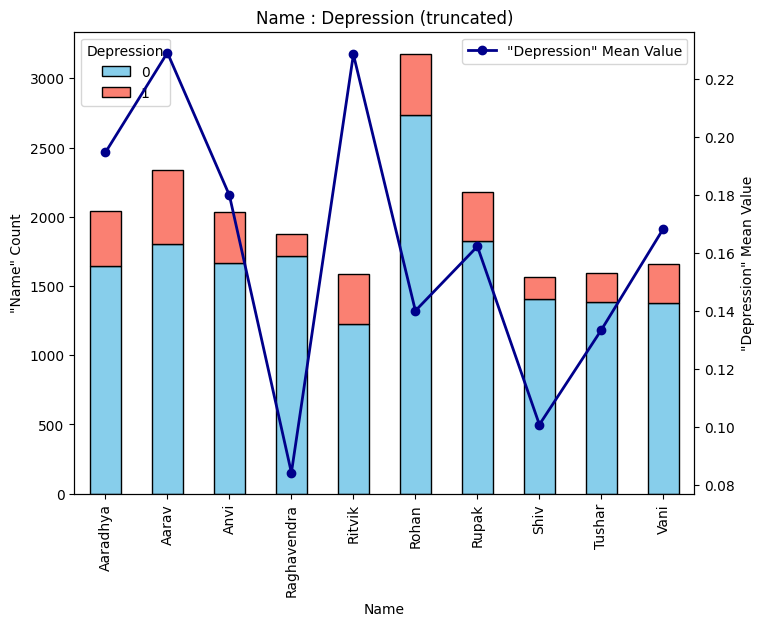

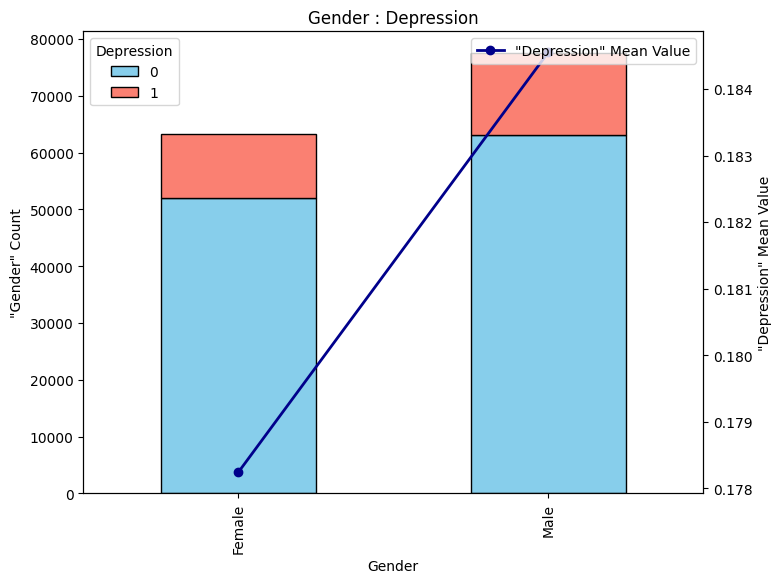

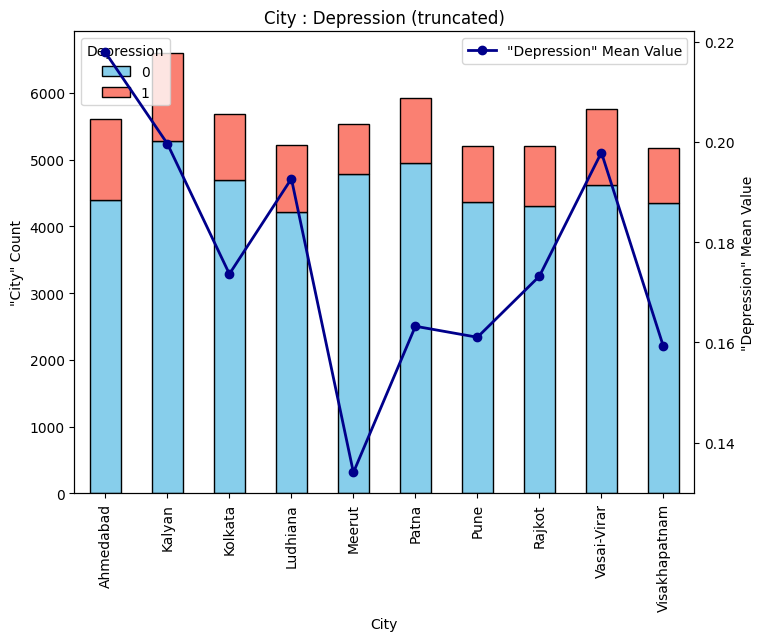

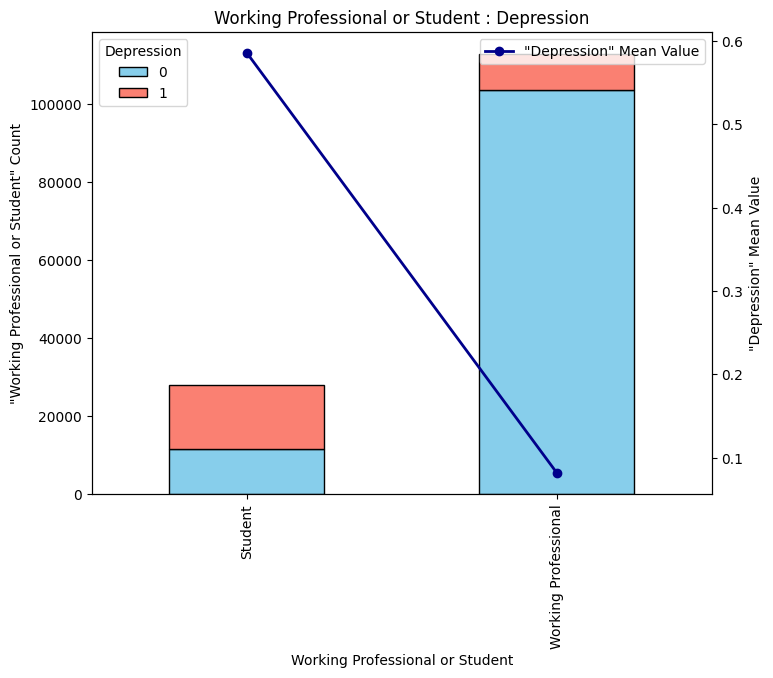

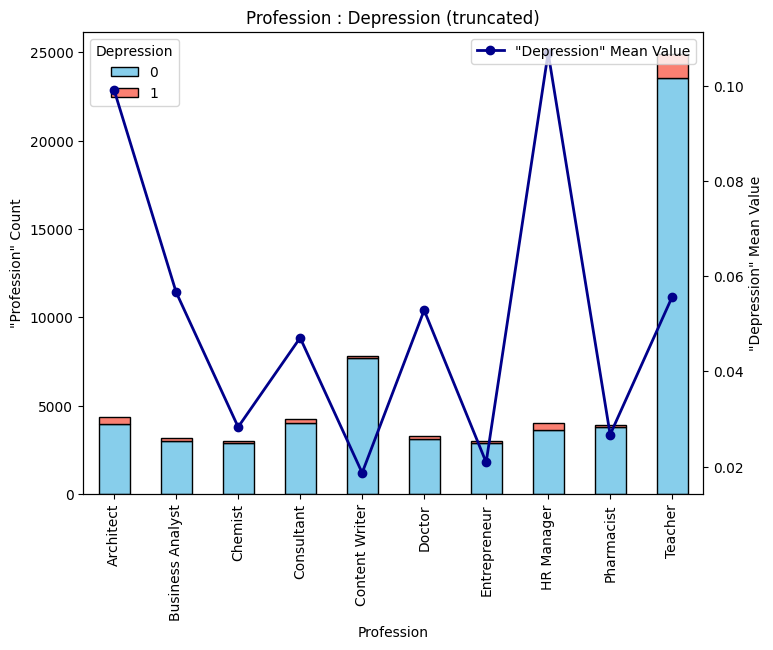

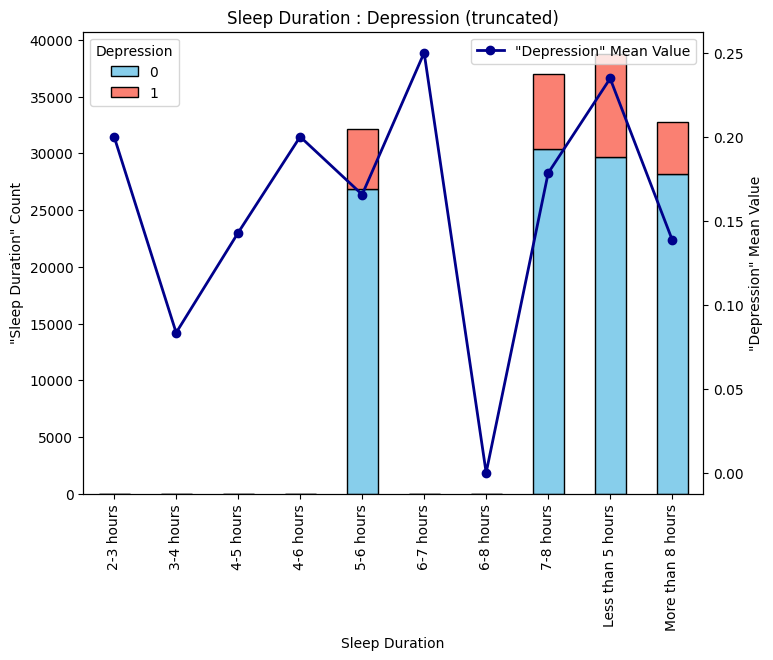

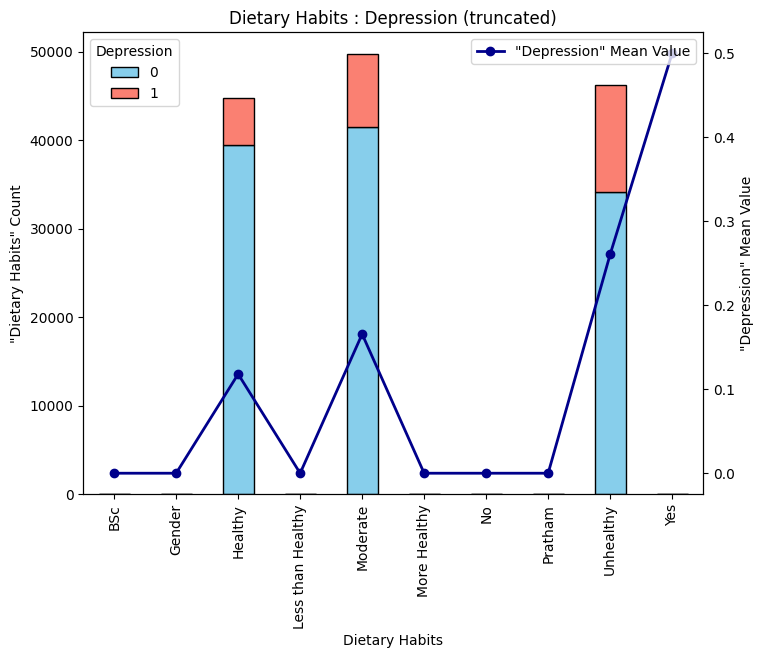

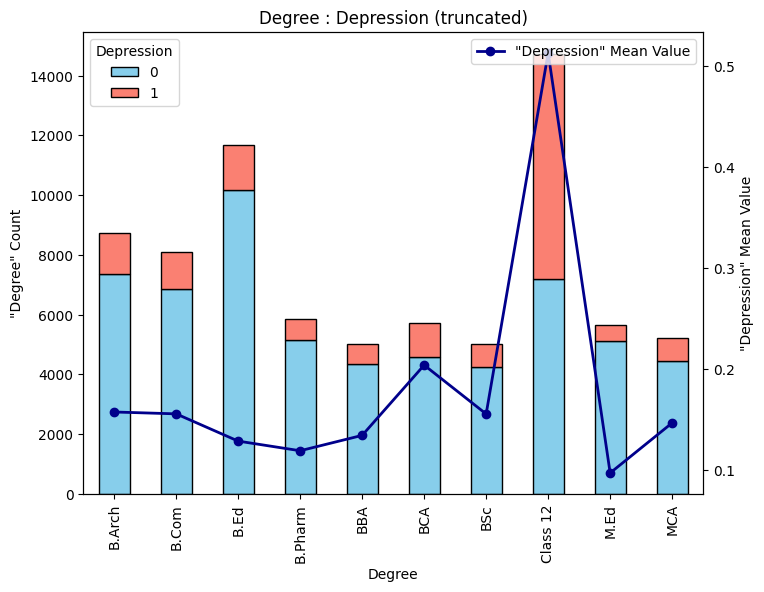

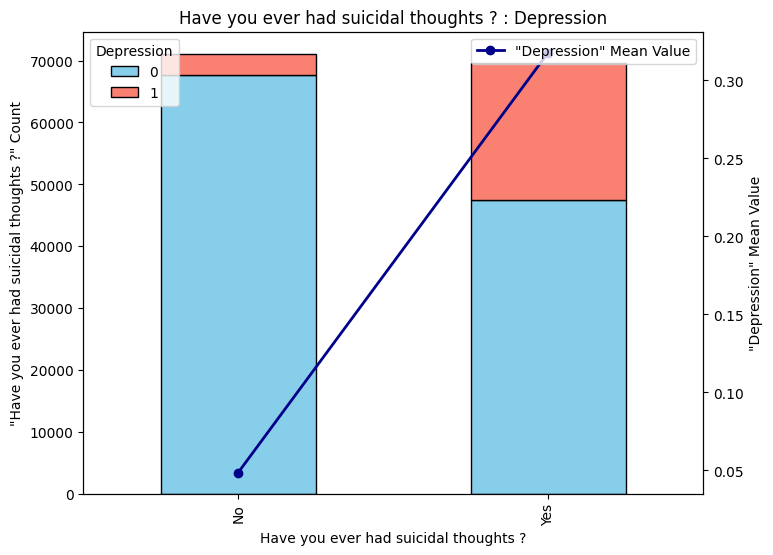

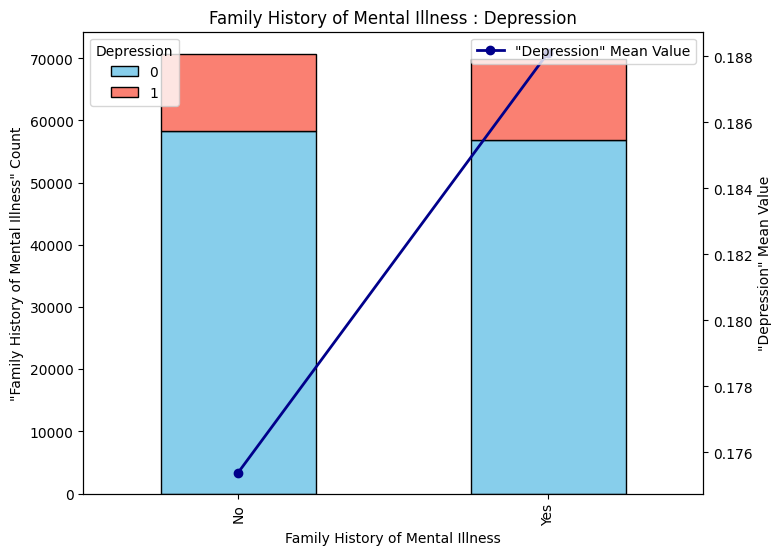

In [106]:
for col in categorical_cols:
    top_categoris = train_df[col].value_counts().nlargest(10).index
    filtered_df = train_df[train_df[col].isin(top_categoris)]

    title = f"{col} : {target_col}"

    if len(filtered_df) < len(train_df):
        title += " (truncated)"

    grouped_df = filtered_df.groupby(col)[target_col]

    # 積み上げ棒グラフ
    ax = (
        grouped_df.value_counts()
        .unstack()
        .plot(
            kind="bar",
            stacked=True,
            color=["skyblue", "salmon"],
            edgecolor="black",
            figsize=(8, 6),
        )
    )

    # 重ねるデータ（平均値）の計算
    mean_values = grouped_df.mean()

    # 平均値を折れ線として重ねる
    mean_values.plot(
        kind="line",
        color="darkblue",
        marker="o",
        ax=ax,
        secondary_y=True,
        linewidth=2,
        label="Mean Value",
    )

    # ラベルや凡例の設定
    ax.set_xlabel(col)
    ax.set_ylabel(f'"{col}" Count')
    ax.right_ax.set_ylabel(f'"{target_col}" Mean Value')
    ax.set_title(title)

    # x軸の項目名を垂直に設定
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # 凡例の調整
    ax.legend(title=target_col, loc="upper left")
    ax.right_ax.legend([f'"{target_col}" Mean Value'], loc="upper right")

    plt.show()


**追加で調べたこと**

- このデータの`City`はインドの都市
- `Degree`の`Class 12`は日本の高校3年生に相当し、基本は18歳が有する大学進学資格

**グラフから分かること**

- `Name`と`City`はばらついている
- `Gender`と`Family History of Mental Illness`内での差はほぼない
- `Working Professional or Student`では、`Student`の`Depression`率が高い
- `Profession`は、`Architect`と`HR Manager`が他の職種より圧倒的に`Depression`率が高い
- `Sleep Duration`は、`Less than 5 hours`と`More than 8 hours`で大きな差がある
- `Dietary Habits`は、`Healty`と`Unhealthy`で大きな差がある
- `Degree`は、大半は0.1~0.2程に収まっているが、`Class 12`だけ圧倒的に高い
- `Have you ever had suicidal thoughts ?`は、`Yes`が圧倒的に高い

## 数値データ

<Axes: >

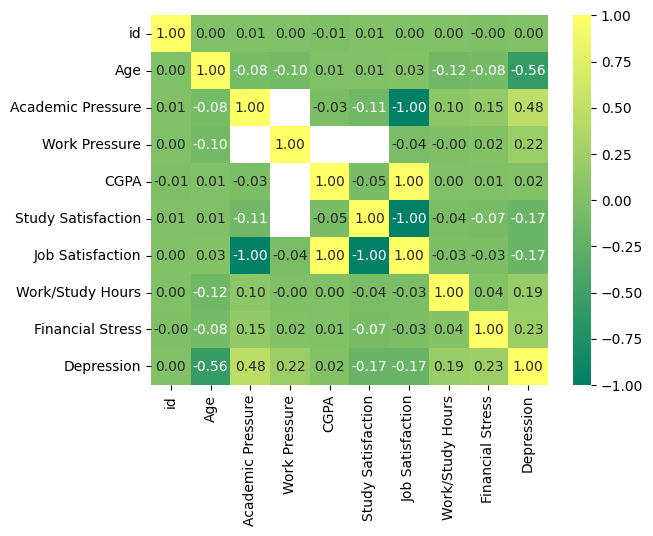

In [107]:
sns.heatmap(
    train_df[numerical_cols + [target_col]].corr(), cmap="summer", annot=True, fmt=".2f"
)

**追加で調べたこと**

- `CGPA`は全科目の成績の平均

**グラフから分かること**
- `id`はどの特徴量とも相関がない
- `Age`、`Academic Pressure`は、`Depression`との相関がとても強い
- `Financial Stress`、`Work Pressure`も`Depression`との相関が強い
- `Work/Study Hours`、`Study Satisfaction`、`Job Satisfaction`もそれなりに`Depression`と相関がある

- `Academic Pressure`と`Job Satisfaction`、`Study Satisfaction`と`Job Satisfaction`では、とても相関が強い

## カテゴリカルデータと数値データの分析からの考察

`Name`と`City`のばらつきの多さは、たまたま学生が集中している種程、`Depression`率が高くなってしまっている？

→　`Name`と`City`内での`Working Professional or Student`の分布を調べる

`Gender`と`Family History of Mental Illness`内で、たまたま`Depression`率が打ち消し合う分布になってしまっている？

→`Gender`、`Family History of Mental Illness`毎の`Working Professional or Student`や、`Age`、`Academic Pressure`等の分布を調べる

`Degree`が`Class 12`だと`Depression`率が高いのはほとんどが学生だから？

→　`Class 12`での学生の割合を、他の`Degree`と比較

`Academic Pressure`と`Job Satisfaction`間、`Study Satisfaction`と`Job Satisfaction`間で相関が強いのは、学生向けの質問と社会人向けの質問であり、ほとんどの人はどちらかしか答えていないのでは？

→それぞれの回答状況を`Working Professional or Student`で比較する

これから行う検証の結果によって、モデルの学習に使う特徴量と、使わない特徴量を判断する

In [108]:
features = train_df.columns.tolist()
remove_features = []

print(f"{features = }")

features = ['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


`id`はどの特徴量とも相関がなさそうなので、モデルの学習に使わない

In [109]:
features.remove("id")
remove_features.append("id")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
remove_features = ['id']


## 追加検証

### `Name`のばらつき

`Depression`への影響が強いものの分布が、`Name`毎に偏っているか調べる

まずはサンプル数が多い`Name`を特定する

In [110]:
print(f'名前の種類数:{len(train_df["Name"].unique())}')

名前の種類数:422


In [111]:
major_names = train_df["Name"].value_counts().nlargest(100).index
major_names_df = train_df[train_df["Name"].isin(major_names)]
major_names_df["Name"].value_counts()

Name
Rohan       3178
Aarav       2336
Rupak       2176
Aaradhya    2045
Anvi        2035
            ... 
Anirudh      606
Arnav        595
Aahana       593
Aarti        586
Pallavi      586
Name: count, Length: 100, dtype: int64

In [112]:
print(f"上位100種の名前の割合：{len(major_names_df) / len(train_df) :.2f}")

上位100種の名前の割合：0.73


サンプル数上位`100`の中で、最も多いのは`Rohan`で`3178`人、最も少ないのは`Pallavi`で`586`人

サンプル数上位`100`は全体の`73`%になる

今回は、これらを対象に調査する

`Working Professional or Student`の`Student`が多いため、`Depression`率が高くなっている可能性を確認

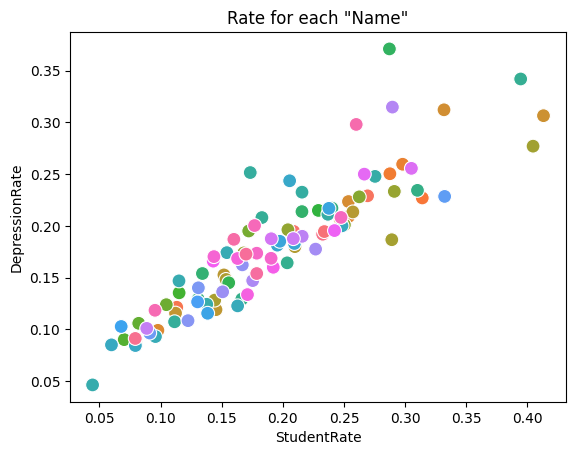

In [113]:
name_stats = (
    major_names_df.groupby("Name")
    .agg(
        StudentRate=(
            "Working Professional or Student",
            lambda x: (x == "Student").mean(),
        ),
        DepressionRate=("Depression", "mean"),
    )
    .reset_index()
)

sns.scatterplot(
    data=name_stats,
    x="StudentRate",
    y="DepressionRate",
    hue="Name",
    s=100,
    legend=False,
)

plt.title('Rate for each "Name"')
plt.show()

各点が、同一の名前の集計結果になっている

`Student`の割合が高い程、`Depression`率が高くなっている

→　`Name`毎に`Depression`率に差があったのは、`Student`の分布に偏りがあったためと考えられる

→　よって、計算コストや過剰適合に配慮すると、`Name`は特徴量として使うべきではない

In [114]:
features.remove("Name")
remove_features.append("Name")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
remove_features = ['id', 'Name']


### `City`のばらつき

`Name`同様、`Student`と`Depression`の関係を都市ごとに確認してみる

まずはサンプル数が多い`Name`を特定する

In [115]:
print(f'都市の種類数:{len(train_df["City"].unique())}')

都市の種類数:98


In [116]:
major_cities = train_df["City"].value_counts().nlargest(20).index
major_cities_df = train_df[train_df["City"].isin(major_cities)]
major_cities_df["City"].value_counts()

City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Srinagar         5074
Mumbai           4966
Indore           4872
Agra             4684
Surat            4636
Varanasi         4606
Vadodara         4568
Hyderabad        4496
Kanpur           4398
Jaipur           4328
Name: count, dtype: int64

In [117]:
print(f"上位20種の都市の割合：{len(major_cities_df) / len(train_df) :.2f}")

上位20種の都市の割合：0.73


サンプル数上位`20`の中で、最も多いのは`Kalyan`で`6591`人、最も少ないのは`Jaipur`で`4328`人

サンプル数上位`20`は全体の`73`%になる

今回は、これらを対象に調査する

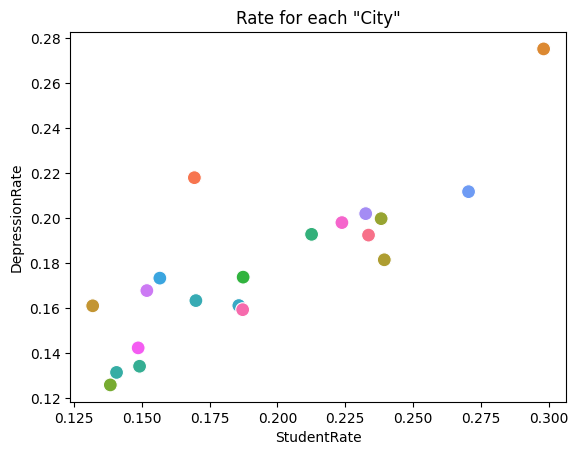

In [118]:
city_stats = (
    major_cities_df.groupby("City")
    .agg(
        StudentRate=(
            "Working Professional or Student",
            lambda x: (x == "Student").mean(),
        ),
        DepressionRate=("Depression", "mean"),
    )
    .reset_index()
)

sns.scatterplot(
    data=city_stats,
    x="StudentRate",
    y="DepressionRate",
    hue="City",
    s=100,
    legend=False,
)

plt.title('Rate for each "City"')
plt.show()

各点が、同一の都市の集計結果になっている

`Name`同様、`Student`の割合が高い程、`Depression`率が高くなっている

→　`City`毎に`Depression`率に差があったのは、`Student`の分布に偏りがあったためと考えられる

→　よって、計算コストや過剰適合に配慮すると、`City`は特徴量として使うべきではない

In [119]:
features.remove("City")
remove_features.append("City")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Gender', 'Age', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
remove_features = ['id', 'Name', 'City']


### `Gender`に対する他の特徴量の影響

`Gender`だけでは、`Depression`に明確な差は見受けられなかったのは、他の特徴量の分布が`Depression`を相殺する関係になっていた可能性を考える

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


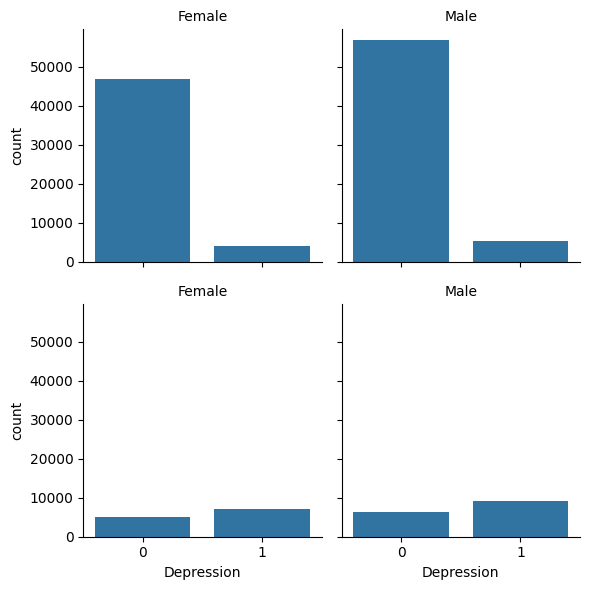

In [120]:
grid = sns.FacetGrid(train_df, col="Gender", row="Working Professional or Student")
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


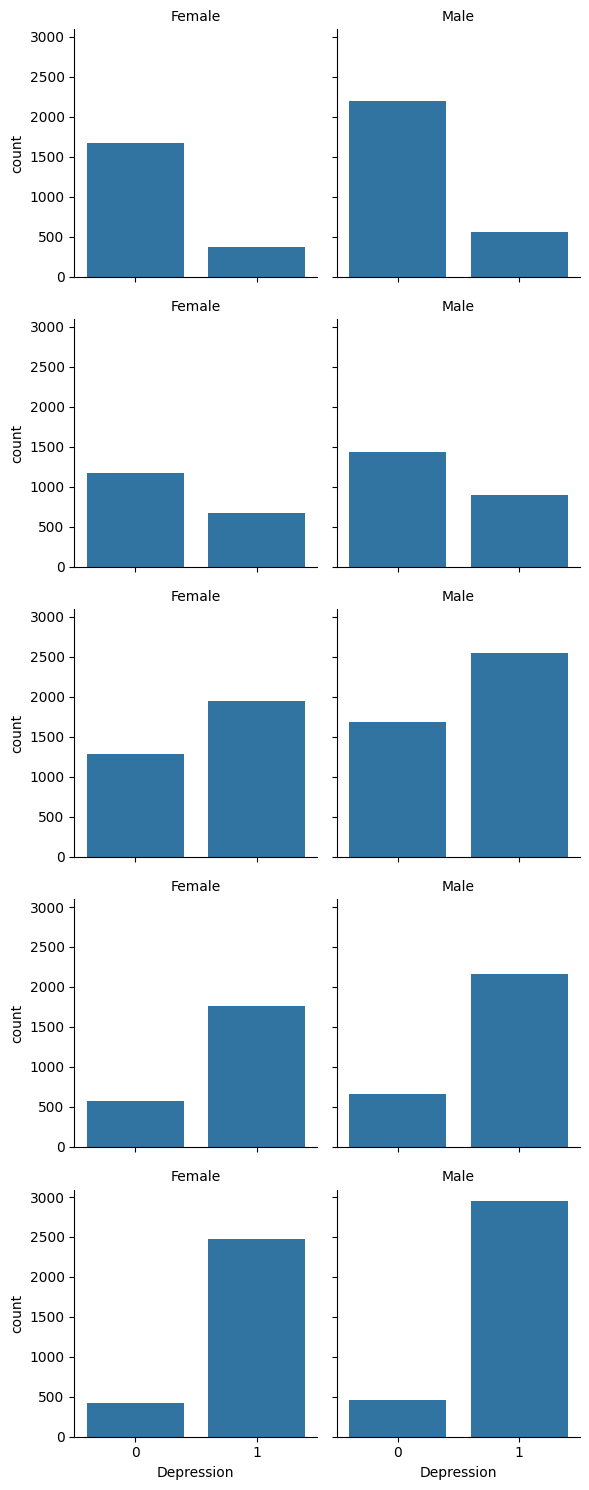

In [121]:
grid = sns.FacetGrid(train_df, col="Gender", row="Academic Pressure")
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


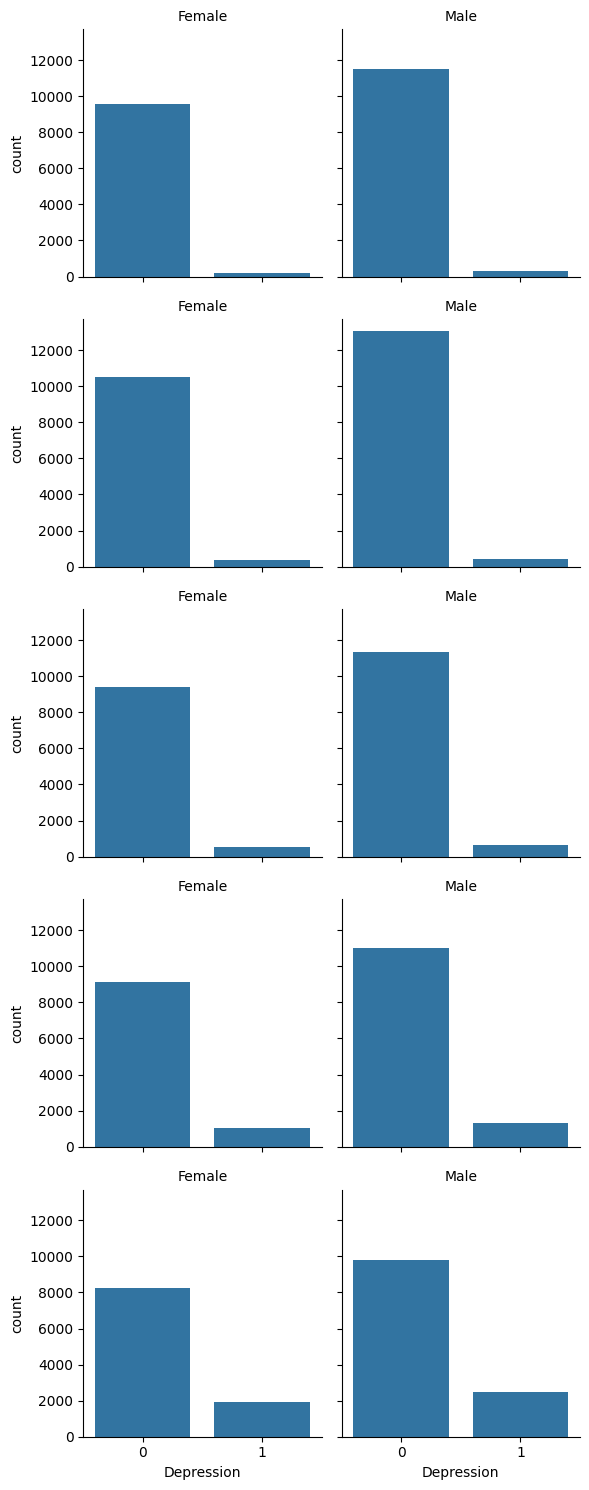

In [122]:
grid = sns.FacetGrid(train_df, col="Gender", row="Work Pressure")
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

全体数による差はあれど、`Depression`率の傾向に明確な差は見受けられない

→　`Depression`率に性差は見受けられない

→　よって`Gender`は特徴量として使わない

In [123]:
features.remove("Gender")
remove_features.append("Gender")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Age', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
remove_features = ['id', 'Name', 'City', 'Gender']


### `Family History of Mental Illness`に対する他の特徴量の影響

`Gender`同様、他の特徴量が`Depression`を相殺する分布になっていないか確認する

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


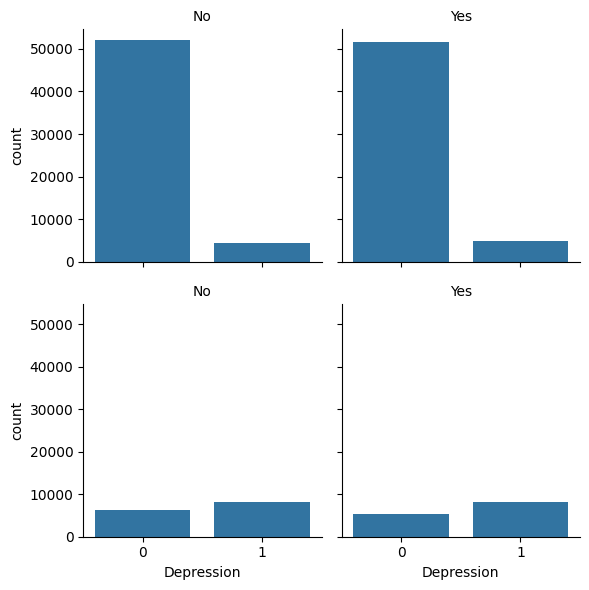

In [124]:
grid = sns.FacetGrid(
    train_df,
    col="Family History of Mental Illness",
    row="Working Professional or Student",
)
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


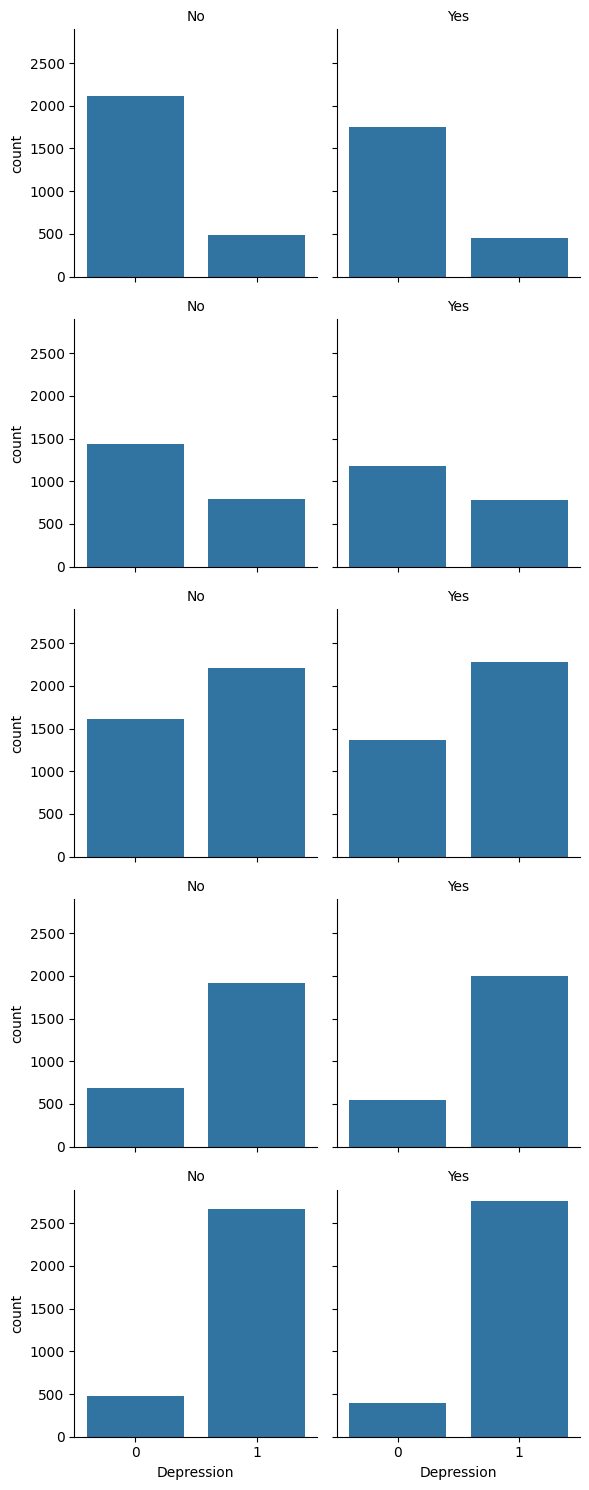

In [125]:
grid = sns.FacetGrid(
    train_df, col="Family History of Mental Illness", row="Academic Pressure"
)
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


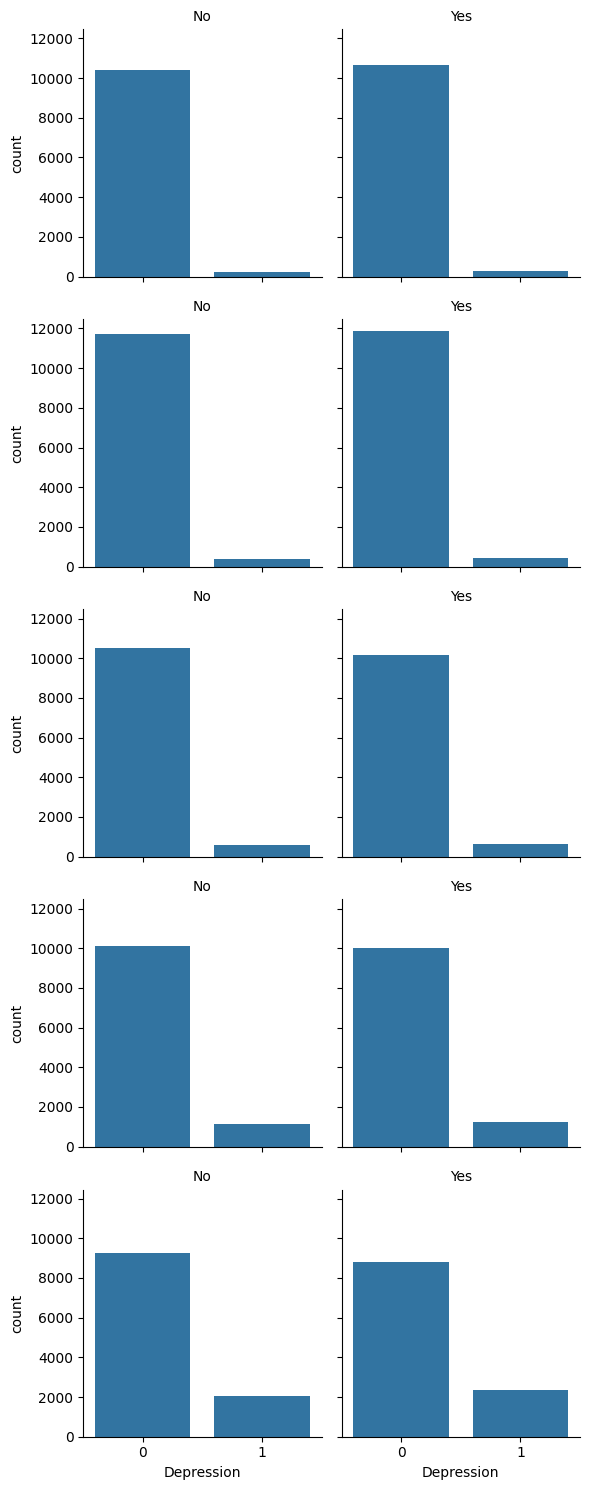

In [126]:
grid = sns.FacetGrid(
    train_df, col="Family History of Mental Illness", row="Work Pressure"
)
grid.map(sns.countplot, "Depression")
grid.set_titles("{col_name}")

plt.show()

`Gender`同様、全体数による差はあれど、`Depression`率の傾向に明確な差は見受けられない

→　`Depression`率に、家族の精神疾患歴の影響は見受けられない

→　よって`Family History of Mental Illness`は特徴量として使わない

In [127]:
features.remove("Family History of Mental Illness")
remove_features.append("Family History of Mental Illness")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Age', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Depression']
remove_features = ['id', 'Name', 'City', 'Gender', 'Family History of Mental Illness']


### `Degree`の`Class 12`で、`Depression`率が高い

`Degree`も、`Name`や`City`同様、`Student`率と`Depression`率に相関が確認できる

主要な`Degree`を確認してみる

In [128]:
major_degrees = train_df["Degree"].value_counts().nlargest(20)
major_degrees

Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
Name: count, dtype: int64

`Class 12`が一番多くて、`14729`人

In [129]:
major_degrees_df = train_df[train_df["Degree"].isin(major_degrees.index)]
print(f"主要な学位の割合：{len(major_degrees_df)/len(train_df) :.2f}")

主要な学位の割合：0.84


上位`20`で全体の`84`%

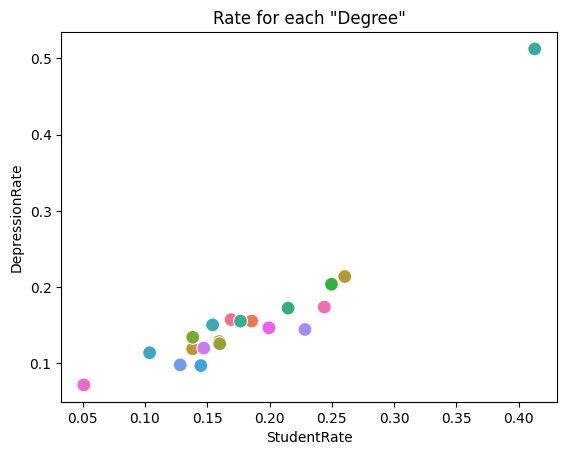

In [130]:
city_stats = (
    major_degrees_df.groupby("Degree")
    .agg(
        StudentRate=(
            "Working Professional or Student",
            lambda x: (x == "Student").mean(),
        ),
        DepressionRate=("Depression", "mean"),
    )
    .reset_index()
)

sns.scatterplot(
    data=city_stats,
    x="StudentRate",
    y="DepressionRate",
    hue="Degree",
    s=100,
    legend=False,
)

plt.title('Rate for each "Degree"')
plt.show()

`Class 12`の`Depression`が高かったのは、`Student`率が高かったことによるものと推察される

また、`Degree`全体でも、`Student`率と`Depression`率に強い相関があることが確認された

→　計算コストや過剰適合に配慮すると、`Degree`は特徴量として使用するべきではない

In [131]:
features.remove("Degree")
remove_features.append("Degree")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Age', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Depression']
remove_features = ['id', 'Name', 'City', 'Gender', 'Family History of Mental Illness', 'Degree']


### `Job Satisfaction`と、`Academic Pressure`・`Study Satisfaction`間の相関の強さ

恐らく、`Working Professional or Student`が`Working Professional`向けの項目が`Job Satisfaction`で、`Student`向けの項目が`Academic Pressure`と`Study Satisfaction`だと思われる

各サンプルが、自分の`Working Professional or Student`に応じて回答する対象が異なり、その結果が相関の強さに繋がったのではないだろうか？

`Working Professional or Student`毎に、`Job Satisfaction`、`Academic Pressure`、`Study Satisfaction`の回答状況を確認する

まずは、`Job Satisfaction`の回答状況

<Axes: xlabel='Job Satisfaction', ylabel='count'>

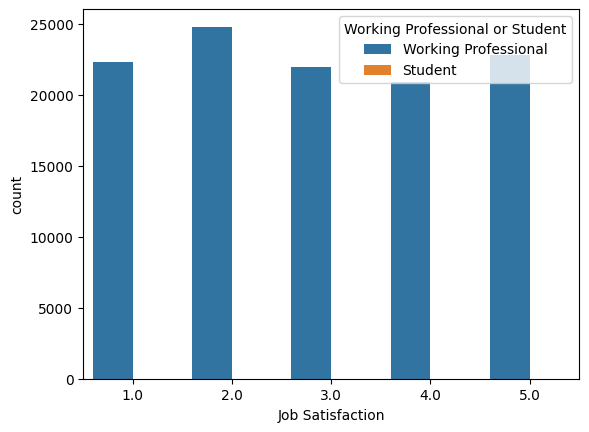

In [132]:
sns.countplot(train_df, x="Job Satisfaction", hue="Working Professional or Student")

In [133]:
only_student = train_df["Working Professional or Student"] == "Student"
train_df[only_student]["Job Satisfaction"].value_counts()

Job Satisfaction
2.0    3
4.0    2
1.0    2
3.0    1
Name: count, dtype: int64

グラフ上では確認できない程、`Job Satisfaction`への`Student`の回答はなく、`8`人だけだった

次に、`Academic Pressure`の確認

<Axes: xlabel='Academic Pressure', ylabel='count'>

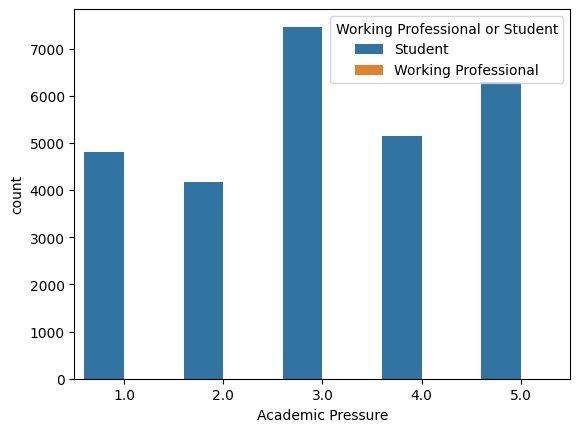

In [134]:
sns.countplot(train_df, x="Academic Pressure", hue="Working Professional or Student")

In [135]:
only_working_pro = train_df["Working Professional or Student"] == "Working Professional"
train_df[only_working_pro]["Academic Pressure"].value_counts()

Academic Pressure
4.0    3
2.0    1
3.0    1
Name: count, dtype: int64

`Academic Pressure`に回答している`Working Professional`は`5`人だけだった

最後に、`Study Satisfaction`の回答状況を確認する

<Axes: xlabel='Study Satisfaction', ylabel='count'>

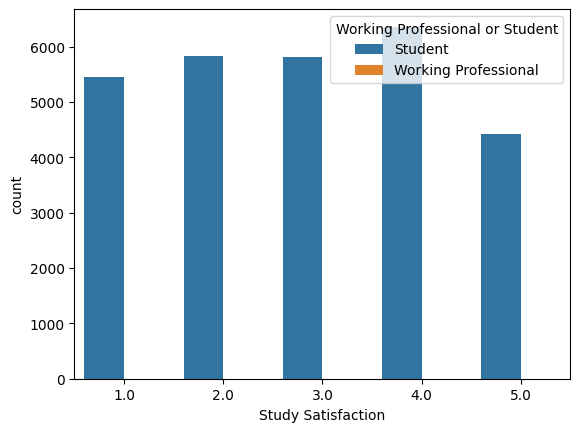

In [136]:
sns.countplot(train_df, x="Study Satisfaction", hue="Working Professional or Student")

In [137]:
train_df[only_working_pro]["Study Satisfaction"].value_counts()

Study Satisfaction
3.0    2
2.0    2
5.0    1
4.0    1
Name: count, dtype: int64

`Study Satisfaction`に回答している`Working Professional`は`6`人だけだった

それぞれの確認結果から、やはり、`Job Satisfaction`は`Working Professional`向け、`Academic Pressure`と`Study Satisfaction`は`Student`向けの項目であったと思われる

ヒートマップの相関関係に違和感はなかったが、同様の理由で、恐らく`Working Professional`向けの項目であろう`Work Pressure`に回答している`Student`も確認してみる

In [138]:
train_df[only_student]["Work Pressure"].value_counts()

Work Pressure
5.0    2
2.0    1
Name: count, dtype: int64

`Work Pressure`に回答している`Student`は`3`人

一見属性に合わないような回答をしている人物がごくわずかにいたが、`Working Professional`か`Student`で明確に分けられる人物ではなく、例えば、仕事をしながら学校に通っている可能性もある

不適切なデータであると断定できない以上、むやみに手を加えるわけにもいかないため、このままモデルの学習に使用する

# 前処理

## 異常値への対処


==============================train==============================



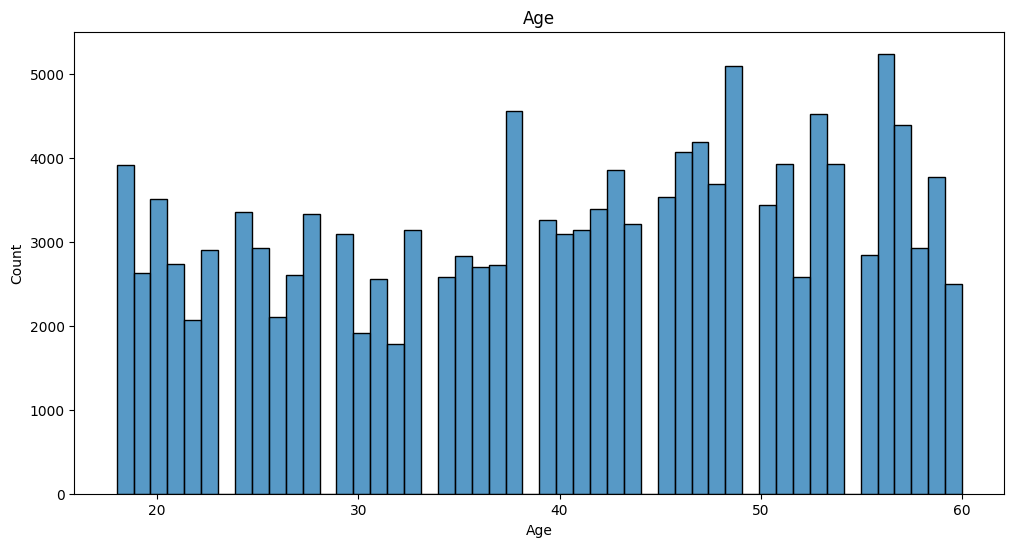

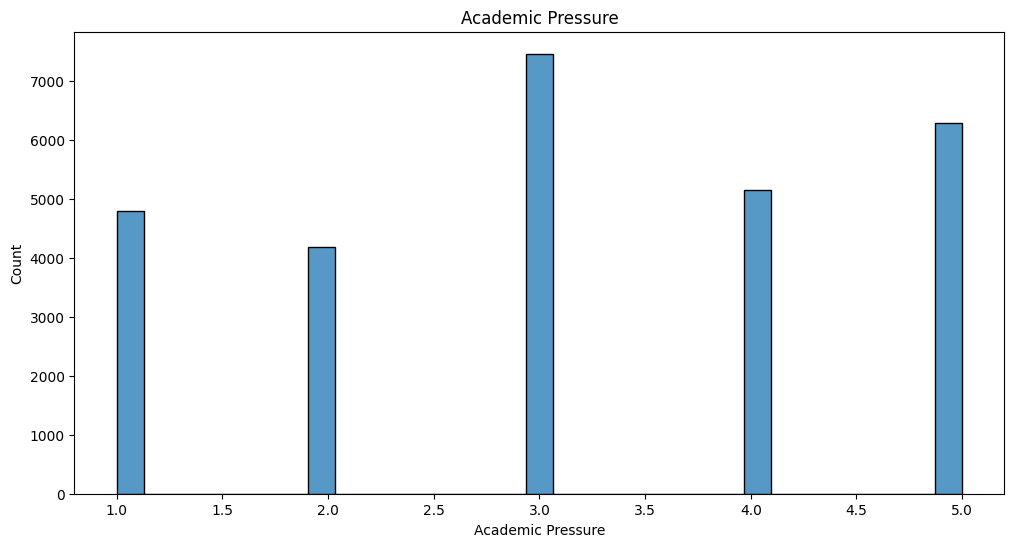

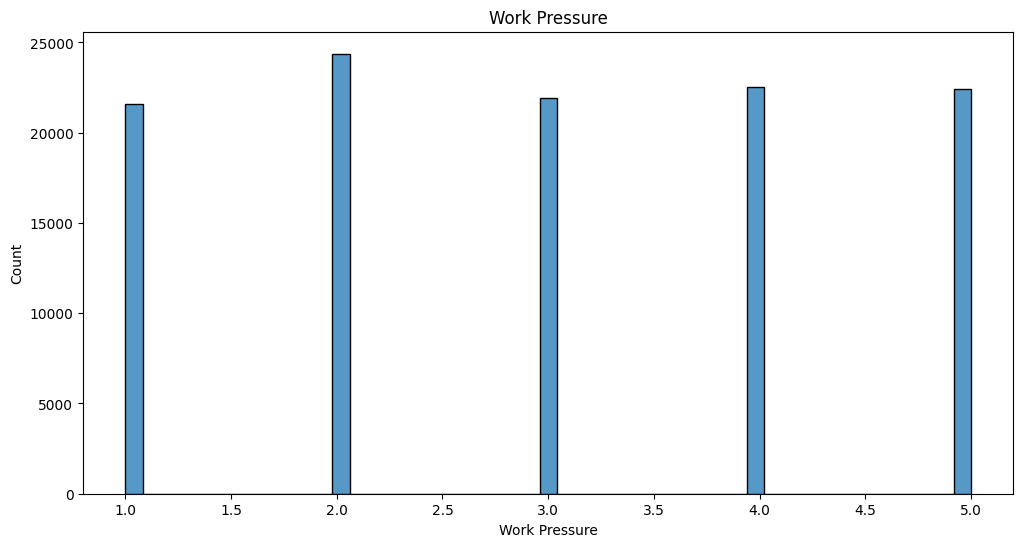

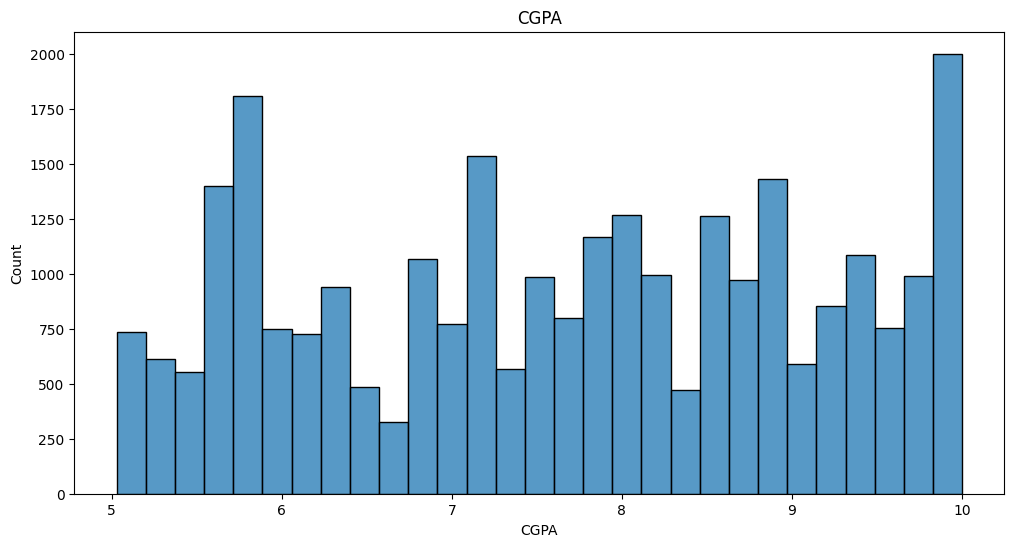

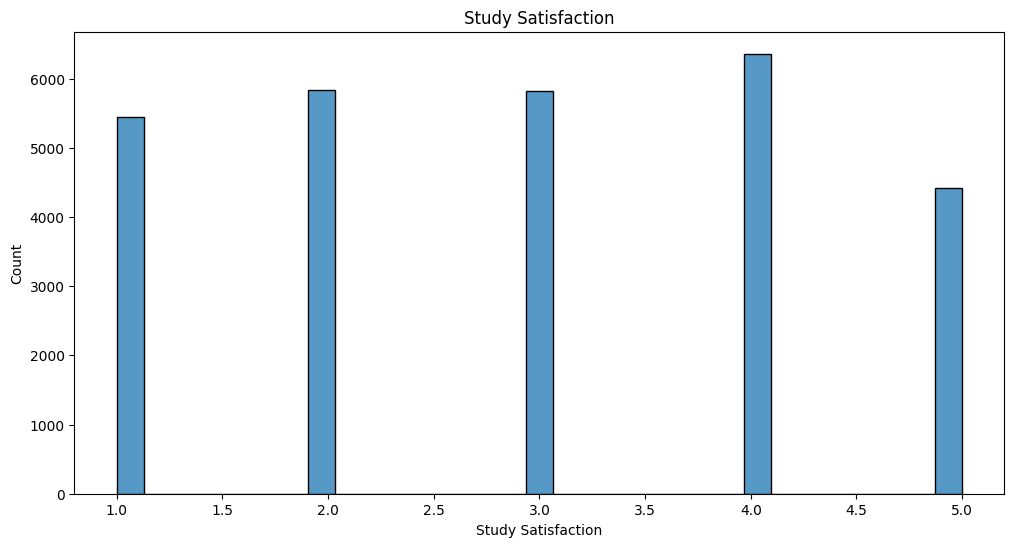

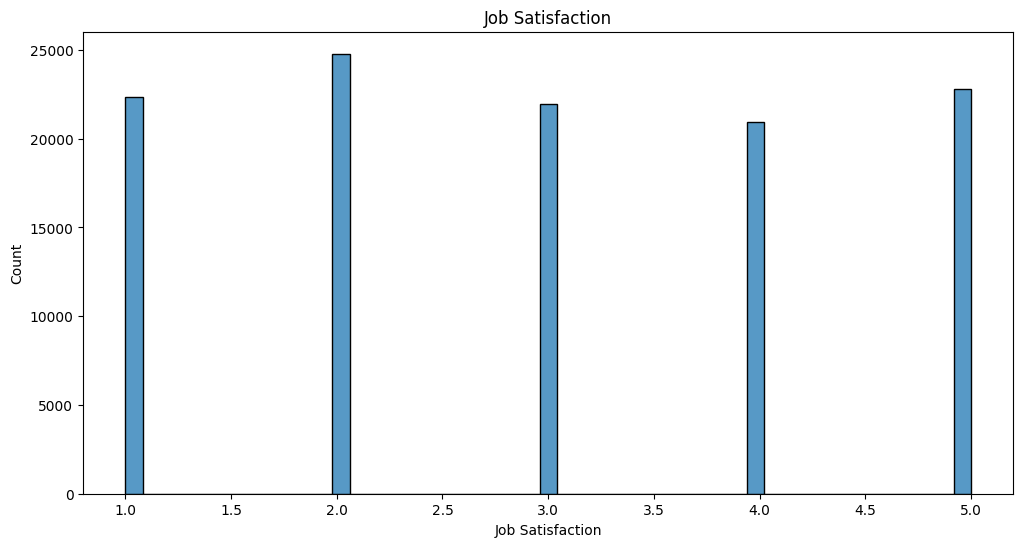

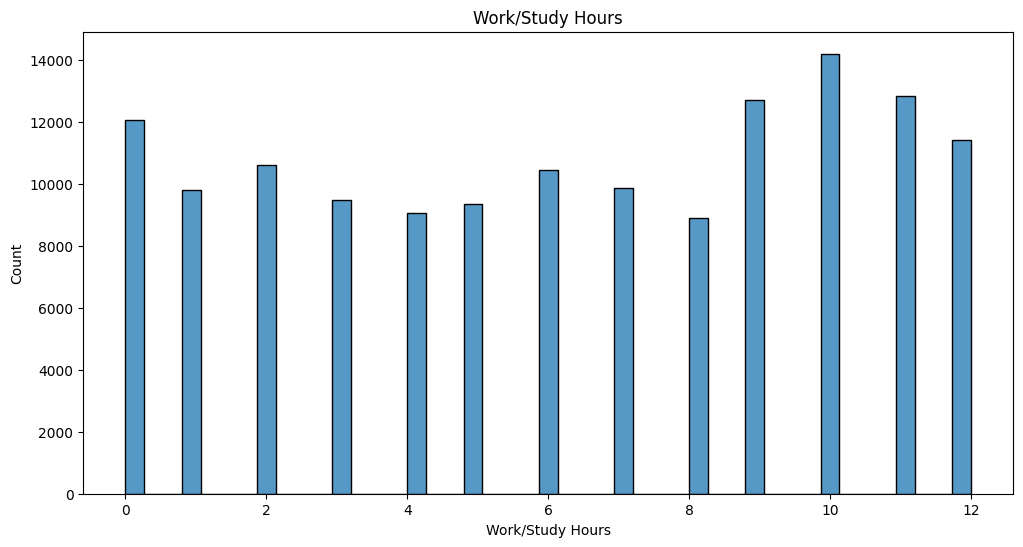

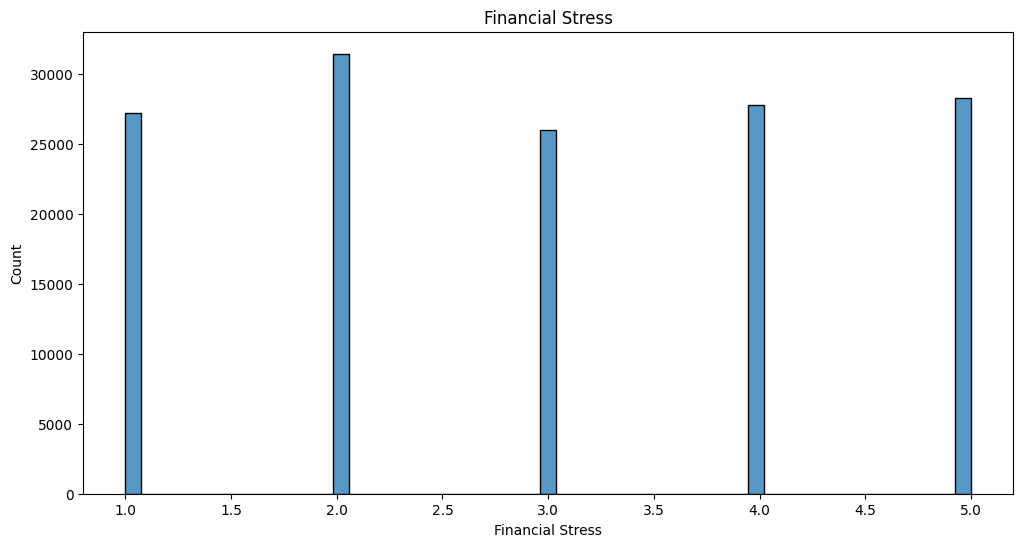


==============================test==============================



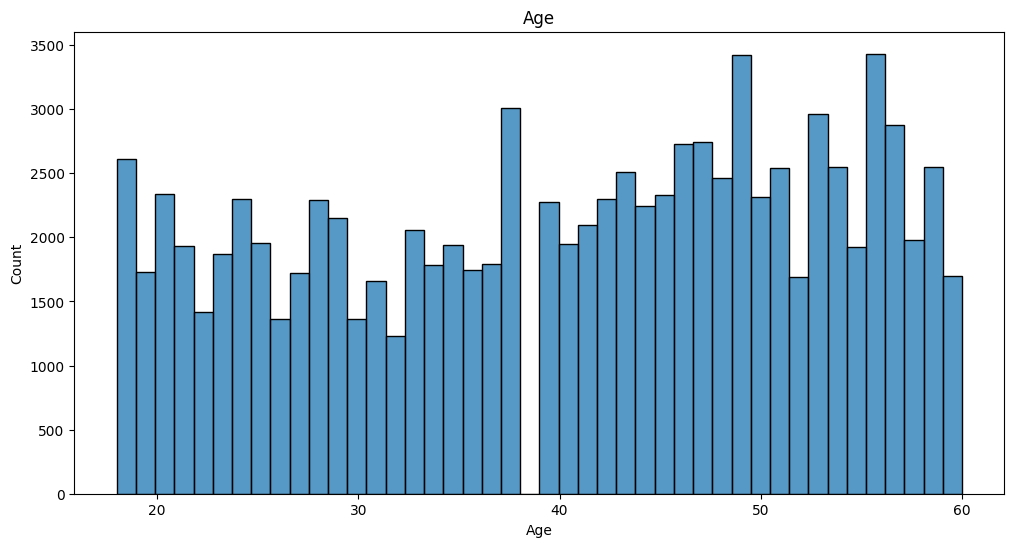

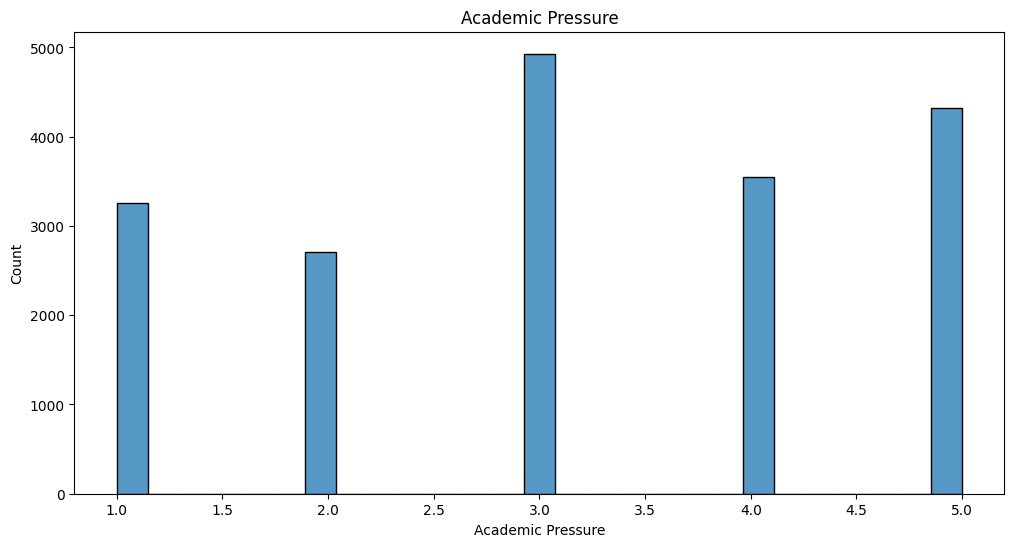

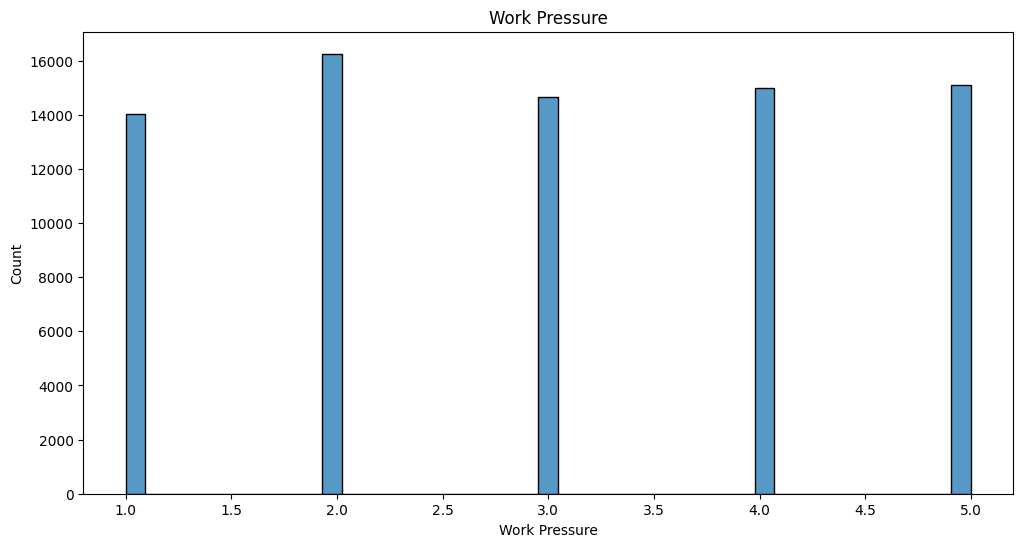

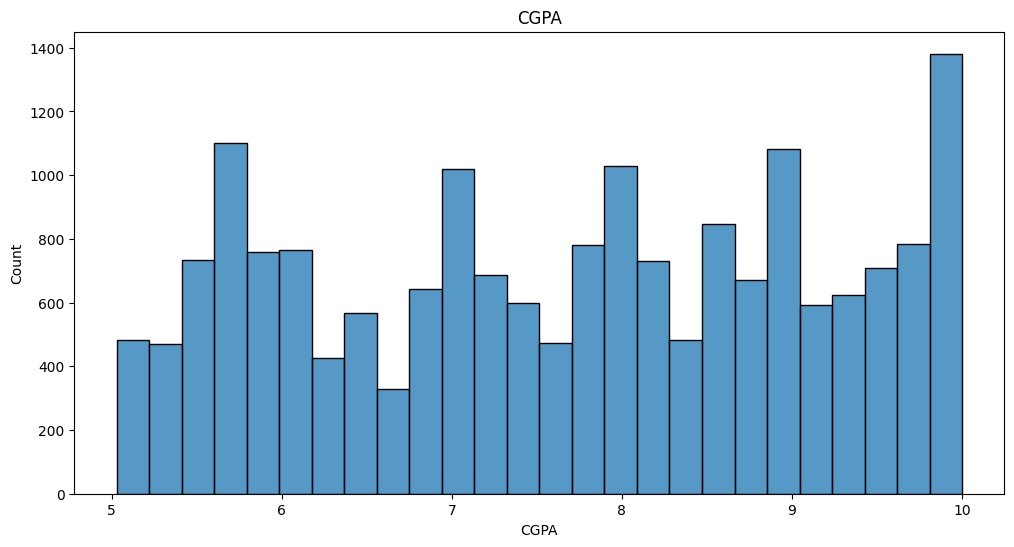

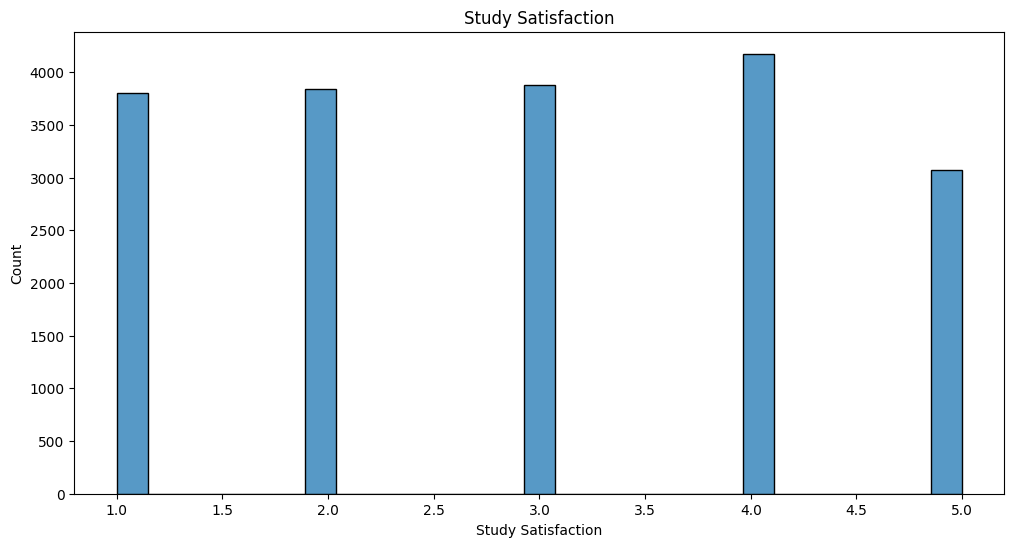

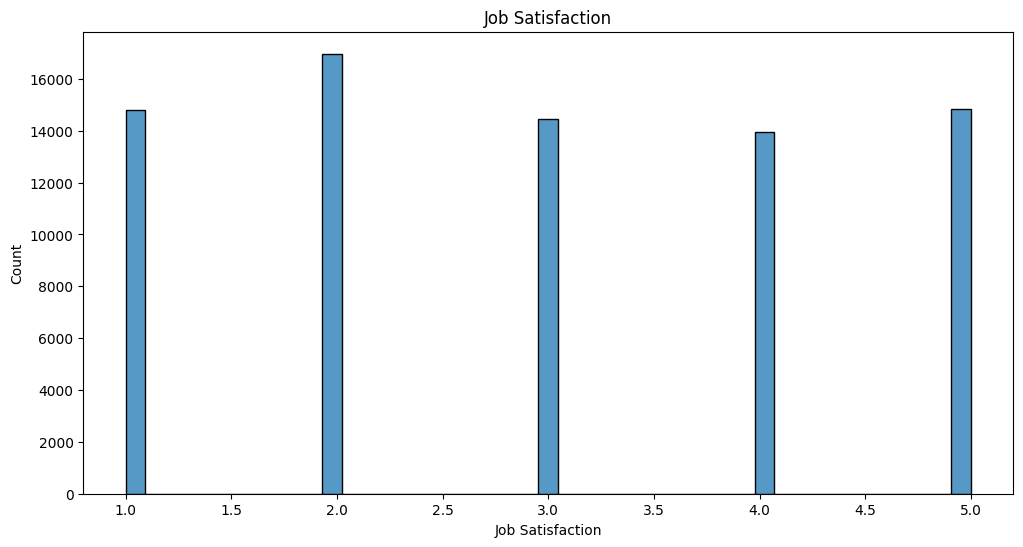

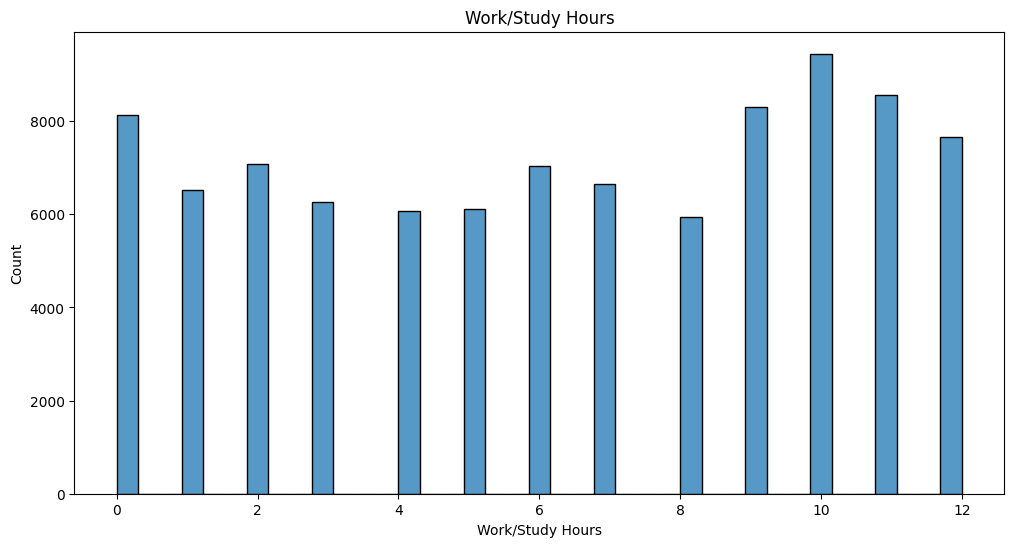

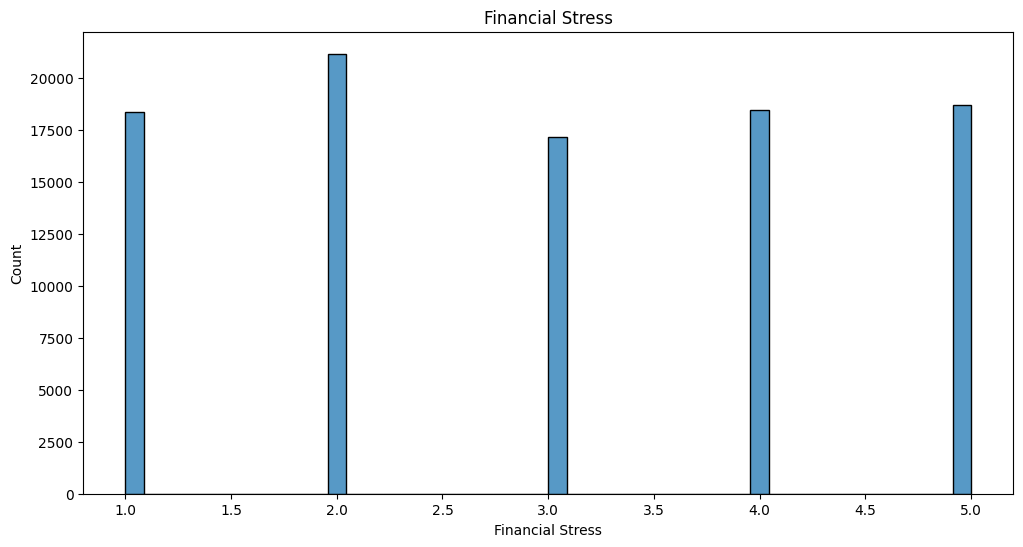

In [139]:
dfs_title = ["train", "test"]

for title, df in zip(dfs_title, dfs):
    print(f"\n=============================={title}==============================\n")
    for col in numerical_cols:
        if col in remove_features:
            continue

        plt.figure(figsize=(12, 6))
        sns.histplot(df[col])
        plt.title(col)
        plt.show()

異常値はなさそう

## 欠損値の補完

In [140]:
utils.check_dfs_null(dfs)

train:
Profession: 36630/140700
Academic Pressure: 112803/140700
Work Pressure: 27918/140700
CGPA: 112802/140700
Study Satisfaction: 112803/140700
Job Satisfaction: 27910/140700
Dietary Habits: 4/140700
Degree: 2/140700
Financial Stress: 4/140700

test:
Profession: 24632/93800
Academic Pressure: 75033/93800
Work Pressure: 18778/93800
CGPA: 75034/93800
Study Satisfaction: 75033/93800
Job Satisfaction: 18774/93800
Dietary Habits: 5/93800
Degree: 2/93800



`CGPA`は欠損値が多すぎるので、モデルの学習には使わない

また、`Degree`は探索的データ分析により、モデルの学習に使わないことにしたため、欠損値の補完は必要ない

In [141]:
features.remove("CGPA")
remove_features.append("CGPA")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Age', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Depression']
remove_features = ['id', 'Name', 'City', 'Gender', 'Family History of Mental Illness', 'Degree', 'CGPA']


### `Profession`

基本、`Working Professional or Student`が`Student`だと、`Profession`は空欄なので、`Working Professional or Student`列は削除して、`Profession`に、`Student`を入れればいい

また、職種が多すぎるため、`Student`で補完した後も残っている欠損値と、サンプル数が少ない職業は、`Other`としてまとめる

まずは、主要な職業を調べる

In [142]:
major_pros = train_df["Profession"].value_counts().nlargest(30)
major_pros

Profession
Teacher                   24906
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Accountant                 1339
Name: count, dtype: int64

In [143]:
print(
    f'{major_pros.sum()/len(train_df[train_df['Working Professional or Student'] == 'Working Professional']) :.2f}'
)

0.88


サンプル数上位`30`種で社会人全体の`88`%になるので、これら以外の職業や、`Working Professional`だが、欠損値のサンプルを`Other`で埋める

In [144]:
for df in dfs:
    df.loc[
        (df["Working Professional or Student"] == "Student")
        & (df["Profession"].isnull()),
        "Profession",
    ] = "Student"

    df.loc[
        (df["Working Professional or Student"] == "Working Professional")
        & ~df["Profession"].isin(major_pros.index),
        "Profession",
    ] = "Other"

    print(f'欠損値の数：{df['Profession'].isnull().sum()}')

欠損値の数：0
欠損値の数：0


`Working Professional or Student`は学習に使わない

In [145]:
features.remove("Working Professional or Student")
remove_features.append("Working Professional or Student")

print(f"{features = }")
print(f"{remove_features = }")

features = ['Age', 'Profession', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Depression']
remove_features = ['id', 'Name', 'City', 'Gender', 'Family History of Mental Illness', 'Degree', 'CGPA', 'Working Professional or Student']


### `Academic Pressure`

`Profession`の時同様、`Working Professional`か`Student`なのかで対応を変える

`Academic Pressure`は、学生向けの特徴量なので、`Student`は`Academic Pressure`の中央値で補完して、`Working Professional`で欠損しているサンプルでは`0`で補完する

まずは、`Student`の`Academic Pressure`の中央値を取得する

In [146]:
student_academic_pressure_median = float(
    train_df[only_student]["Academic Pressure"].median()
)
student_academic_pressure_median

3.0

欠損値を補完する

In [147]:
for df in dfs:
    df.loc[
        (df["Working Professional or Student"] == "Student")
        & df["Academic Pressure"].isnull(),
        "Academic Pressure",
    ] = student_academic_pressure_median
    df.loc[
        (df["Working Professional or Student"] == "Working Professional")
        & df["Academic Pressure"].isnull(),
        "Academic Pressure",
    ] = 0.0

    print(f'欠損値の数：{df["Academic Pressure"].isnull().sum()}')

欠損値の数：0
欠損値の数：0


### `Work Pressure`

`Academic Pressure`と同様の手法で行うが、`Working Professional`と`Student`を逆にする

`Working Professional`の欠損値は、`Working Professional`の中央値で補完し、`Student`の欠損値は`0`で補完する

まずは、`Working Professional`の`Work Pressure`の中央値を取得する

In [148]:
working_pro_work_pressure_median = float(
    train_df[only_working_pro]["Work Pressure"].median()
)
working_pro_work_pressure_median

3.0

欠損値を補完する

In [149]:
for df in dfs:
    df.loc[
        (df["Working Professional or Student"] == "Working Professional")
        & df["Work Pressure"].isnull(),
        "Work Pressure",
    ] = working_pro_work_pressure_median
    df.loc[
        (df["Working Professional or Student"] == "Student")
        & df["Work Pressure"].isnull(),
        "Work Pressure",
    ] = 0.0

    print(f'欠損値の数：{df["Work Pressure"].isnull().sum()}')

欠損値の数：0
欠損値の数：0


### `Study Satisfaction`

`Academic Pressure`と同様の手法で対処する

まずは、`Student`の`Study Satisfaction`の中央値を取得する

In [150]:
student_study_satisfaction_median = float(
    train_df[only_student]["Study Satisfaction"].median()
)
student_study_satisfaction_median

3.0

欠損値を補完する

In [151]:
for df in dfs:
    df.loc[
        (df["Working Professional or Student"] == "Student")
        & df["Study Satisfaction"].isnull(),
        "Study Satisfaction",
    ] = student_study_satisfaction_median
    df.loc[
        (df["Working Professional or Student"] == "Working Professional")
        & df["Study Satisfaction"].isnull(),
        "Study Satisfaction",
    ] = 0.0

    print(f'欠損値の数：{df["Study Satisfaction"].isnull().sum()}')

欠損値の数：0
欠損値の数：0


### `Job Satisfaction`

`Working Professional`と同様の手法で対処する

まずは、`Working Professional`の`Job Satisfaction`の中央値を取得する

In [152]:
working_pro_job_satisfaction_median = float(
    train_df[only_working_pro]["Job Satisfaction"].median()
)
working_pro_job_satisfaction_median

3.0

欠損値を補完する

In [153]:
for df in dfs:
    df.loc[
        (df["Working Professional or Student"] == "Working Professional")
        & df["Job Satisfaction"].isnull(),
        "Job Satisfaction",
    ] = working_pro_job_satisfaction_median
    df.loc[
        (df["Working Professional or Student"] == "Student")
        & df["Job Satisfaction"].isnull(),
        "Job Satisfaction",
    ] = 0.0

    print(f'欠損値の数：{df["Job Satisfaction"].isnull().sum()}')

欠損値の数：0
欠損値の数：0


### `Dietary Habits`

訓練データも、テストデータも、欠損値は少ないので、訓練データの中で最も多い種で補完する

最も多い種の取得

In [154]:
most_common_habits = train_df["Dietary Habits"].mode()[0]
most_common_habits

'Moderate'

In [155]:
for df in dfs:
    df["Dietary Habits"] = df["Dietary Habits"].fillna(most_common_habits)

    print(f'欠損値の数：{df["Dietary Habits"].isnull().sum()}')

欠損値の数：0
欠損値の数：0


### `Financial Stress`

欠損値は訓練データだけの上、４つしか欠損していない

`Financial Stress`は、`Profession`毎に若干傾向が異なるが、結局中央値は`3.0`になると思われる

だが、念のため、欠損している各サンプルの`Profession`を確認し、それぞれの`Profession`での中央値を確認する

In [156]:
train_df[train_df["Financial Stress"].isnull()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
22377,22377,Manvi,Female,32.0,Varanasi,Student,Student,3.0,0.0,5.64,1.0,0.0,5-6 hours,Healthy,BCA,No,12.0,NaN,No,1
51485,51485,Ishwar,Male,37.0,Hyderabad,Working Professional,Other,0.0,4.0,NaN,0.0,2.0,More than 8 hours,Moderate,Class 12,Yes,9.0,NaN,No,0
68910,68910,Arav,Male,29.0,Hyderabad,Student,Student,2.0,0.0,8.94,3.0,0.0,Less than 5 hours,Unhealthy,B.Ed,No,12.0,NaN,Yes,0
97610,97610,Pari,Female,20.0,Kolkata,Student,Student,1.0,0.0,6.83,1.0,0.0,5-6 hours,Healthy,MBBS,No,9.0,NaN,Yes,0


欠損している４つのサンプルは、`Profession`が`Student`か、`Other`の２種だけなので、それぞれの平均`Financial Stress`を確認する

In [157]:
float(train_df[train_df["Profession"] == "Student"]["Financial Stress"].median())

3.0

In [158]:
float(train_df[train_df["Profession"] == "Other"]["Financial Stress"].median())

3.0

`Student`も、`Other`も平均`3.0`だったので、全部`3.0`で補完する

In [ ]:
train_df["Financial Stress"] = train_df["Financial Stress"].fillna(3.0)

print(f'欠損値の数：{train_df['Financial Stress'].isnull().sum()}')

欠損値の数：0


## 特徴量選択

モデルの学習に使う特徴量と、使わない特徴量を確認する

In [162]:
print(f"使う特徴量：{features}")
print(f"使わない特徴量：{remove_features}")

使う特徴量：['Age', 'Profession', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Depression']
使わない特徴量：['id', 'Name', 'City', 'Gender', 'Family History of Mental Illness', 'Degree', 'CGPA', 'Working Professional or Student']


訓練データとテストデータから、モデルの学習に使わない特徴量を削除する

In [163]:
for df in dfs:
    df.drop(remove_features, axis=1, inplace=True)

In [164]:
train_df

,Age,Profession,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
0,49.0,Chef,0.0,5.0,0.0,2.0,More than 8 hours,Healthy,No,1.0,2.0,0
1,26.0,Teacher,0.0,4.0,0.0,3.0,Less than 5 hours,Unhealthy,Yes,7.0,3.0,1
2,33.0,Student,5.0,0.0,2.0,0.0,5-6 hours,Healthy,Yes,3.0,1.0,1
3,22.0,Teacher,0.0,5.0,0.0,1.0,Less than 5 hours,Moderate,Yes,10.0,1.0,1
4,30.0,Business Analyst,0.0,1.0,0.0,1.0,5-6 hours,Unhealthy,Yes,9.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18.0,Other,0.0,5.0,0.0,4.0,5-6 hours,Unhealthy,No,2.0,4.0,1
140696,41.0,Content Writer,0.0,5.0,0.0,4.0,7-8 hours,Moderate,Yes,6.0,5.0,0
140697,24.0,Marketing Manager,0.0,3.0,0.0,1.0,More than 8 hours,Moderate,No,4.0,4.0,0
140698,49.0,Plumber,0.0,5.0,0.0,2.0,5-6 hours,Moderate,Yes,10.0,1.0,0


In [165]:
test_df

,Age,Profession,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress
0,53.0,Judge,0.0,2.0,0.0,5.0,Less than 5 hours,Moderate,No,9.0,3.0
1,58.0,Educational Consultant,0.0,2.0,0.0,4.0,Less than 5 hours,Moderate,No,6.0,4.0
2,53.0,Teacher,0.0,4.0,0.0,1.0,7-8 hours,Moderate,Yes,12.0,4.0
3,23.0,Student,5.0,0.0,1.0,0.0,More than 8 hours,Moderate,Yes,10.0,4.0
4,47.0,Teacher,0.0,5.0,0.0,5.0,7-8 hours,Moderate,Yes,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
93795,49.0,Pilot,0.0,3.0,0.0,5.0,Less than 5 hours,Moderate,Yes,2.0,2.0
93796,29.0,Pilot,0.0,5.0,0.0,1.0,7-8 hours,Moderate,Yes,11.0,3.0
93797,24.0,Student,1.0,0.0,4.0,0.0,7-8 hours,Moderate,No,7.0,1.0
93798,23.0,Marketing Manager,0.0,4.0,0.0,2.0,5-6 hours,Healthy,Yes,7.0,5.0


モデルの学習（と予測）に使う特徴量だけが残った

## データの変換

### レアカテゴリの処理

`Sleep Duration`と、`Dietary Habits`は、レアカテゴリが残ったままなので、それらを一つのラベルにまとめる

#### `Sleep Duration`

ラベルの種類を確認

In [166]:
train_df["Sleep Duration"].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
4-6 hours                5
2-3 hours                5
6-8 hours                4
No                       4
1-6 hours                4
10-11 hours              2
9-11 hours               2
8-9 hours                2
Sleep_Duration           2
Unhealthy                2
45                       2
40-45 hours              1
1-2 hours                1
1-3 hours                1
9-6 hours                1
55-66 hours              1
Moderate                 1
35-36 hours              1
8 hours                  1
10-6 hours               1
Indore                   1
than 5 hours             1
49 hours                 1
Work_Study_Hours         1
3-6 hours                1
45-48 hours              1
9-5                      1
Pune                     1
9-5 hours                1
Name: count, 

サンプル数上位`4`種以外のラベルはサンプル数全体の数に対してとても少ないので、一つのラベルにまとめてよさそう

だが、いくつかのラベルは上位`4`種にまとめられそうなので、適宜対処する

全ラベルの種類を確認

In [167]:
train_df["Sleep Duration"].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

ラベルの種類から、以下の辞書を基にレアカテゴリを再分類する

In [168]:
sleep_duration_labels = {
    "no change": ["More than 8 hours", "Less than 5 hours", "5-6 hours", "7-8 hours"],
    "More than 8 hours": ["8-9 hours", "9-11 hours"],
    "Less than 5 hours": ["2-3 hours", "3-4 hours", "1-3 hours"],
}

再分類用の関数を定義

In [169]:
def integrate_sleep_duration_rare_category(sleep_duration: str) -> str:
    if sleep_duration in sleep_duration_labels["no change"]:
        return sleep_duration

    if sleep_duration in sleep_duration_labels["More than 8 hours"]:
        return "More than 8 hours"

    if sleep_duration in sleep_duration_labels["Less than 5 hours"]:
        return "Less than 5 hours"

    return "Other"

再分類する

In [170]:
for df in dfs:
    df["Sleep Duration"] = df["Sleep Duration"].apply(
        integrate_sleep_duration_rare_category
    )

結果の確認

In [171]:
train_df["Sleep Duration"].value_counts()

Sleep Duration
Less than 5 hours    38802
7-8 hours            36969
More than 8 hours    32730
5-6 hours            32142
Other                   57
Name: count, dtype: int64

In [172]:
test_df["Sleep Duration"].value_counts()

Sleep Duration
Less than 5 hours    25669
7-8 hours            24491
More than 8 hours    22197
5-6 hours            21404
Other                   39
Name: count, dtype: int64

まとまった

#### `Dietary Habits`

ラベルを確認

In [173]:
train_df["Dietary Habits"].value_counts()

Dietary Habits
Moderate             49709
Unhealthy            46227
Healthy              44741
Yes                      2
More Healthy             2
No                       2
Pratham                  1
Gender                   1
BSc                      1
Less than Healthy        1
3                        1
1.0                      1
Hormonal                 1
Electrician              1
Mihir                    1
No Healthy               1
Less Healthy             1
M.Tech                   1
Vegas                    1
Male                     1
Indoor                   1
Class 12                 1
2                        1
Name: count, dtype: int64

再分類用の辞書の定義

In [174]:
dietary_habits_dic = {
    "no change": ["Healthy", "Unhealthy", "Moderate"],
    "Healthy": ["More Healthy"],
}

再分類用の関数を定義

In [175]:
def integrate_dietary_habits_rare_category(dietary_habits: str) -> str:
    if dietary_habits in dietary_habits_dic["no change"]:
        return dietary_habits

    if dietary_habits in dietary_habits_dic["Healthy"]:
        return "Healthy"

    return "Other"

再分類

In [176]:
for df in dfs:
    df["Dietary Habits"] = df["Dietary Habits"].apply(
        integrate_dietary_habits_rare_category
    )

結果の確認

In [177]:
train_df["Dietary Habits"].value_counts()

Dietary Habits
Moderate     49709
Unhealthy    46227
Healthy      44743
Other           21
Name: count, dtype: int64

In [178]:
test_df["Dietary Habits"].value_counts()

Dietary Habits
Moderate     33023
Unhealthy    30786
Healthy      29968
Other           23
Name: count, dtype: int64

まとまった

### カテゴリカル変数を数値へ変換

#### 方針

（今回は決定木ベースのモデルを使うため、必要はないのだが、一応行う）

現状を確認

In [179]:
train_df

,Age,Profession,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
0,49.0,Chef,0.0,5.0,0.0,2.0,More than 8 hours,Healthy,No,1.0,2.0,0
1,26.0,Teacher,0.0,4.0,0.0,3.0,Less than 5 hours,Unhealthy,Yes,7.0,3.0,1
2,33.0,Student,5.0,0.0,2.0,0.0,5-6 hours,Healthy,Yes,3.0,1.0,1
3,22.0,Teacher,0.0,5.0,0.0,1.0,Less than 5 hours,Moderate,Yes,10.0,1.0,1
4,30.0,Business Analyst,0.0,1.0,0.0,1.0,5-6 hours,Unhealthy,Yes,9.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18.0,Other,0.0,5.0,0.0,4.0,5-6 hours,Unhealthy,No,2.0,4.0,1
140696,41.0,Content Writer,0.0,5.0,0.0,4.0,7-8 hours,Moderate,Yes,6.0,5.0,0
140697,24.0,Marketing Manager,0.0,3.0,0.0,1.0,More than 8 hours,Moderate,No,4.0,4.0,0
140698,49.0,Plumber,0.0,5.0,0.0,2.0,5-6 hours,Moderate,Yes,10.0,1.0,0


**数値になっていないカテゴリカル変数**
- `Profession`
- `Sleep Duration`
- `Dietary Habits`
- `Have you ever had suicidal thoughts ?`

`Profession`は、`sklearn.preprocessing.LabelEncoder.fit_transform`に任せる

`Sleep Duration`、`Dietary Habits`は、順序をつけられそうなので、置き換える数値を指定する

`Have you ever had suicidal thoughts ?`は、`Yes`を`1`、`No`を`0`に置き換える

#### `Profession`

In [ ]:
encoder = LabelEncoder()

for df in dfs:
    df["Profession"] = encoder.fit_transform(df["Profession"])

#### `Sleep Duration`

In [ ]:
train_df["Sleep Duration"].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Other'], dtype=object)

In [ ]:
sleep_duration_int_dic = {
    "More than 8 hours": 1,
    "7-8 hours": 2,
    "5-6 hours": 3,
    "Less than 5 hours": 4,
    "Other": 0,
}

In [ ]:
for df in dfs:
    df["Sleep Duration"] = df["Sleep Duration"].apply(
        lambda duration: sleep_duration_int_dic[duration]
    )

#### `Dietary Habits`

In [ ]:
train_df["Dietary Habits"].unique()

array(['Healthy', 'Unhealthy', 'Moderate', 'Other'], dtype=object)

In [ ]:
dietary_habits_int_dic = {"Healthy": 1, "Moderate": 2, "Unhealthy": 3, "Other": 0}

In [ ]:
for df in dfs:
    df["Dietary Habits"] = df["Dietary Habits"].apply(
        lambda habits: dietary_habits_int_dic[habits]
    )

#### `Have you ever had suicidal thoughts ?`

In [ ]:
for df in dfs:
    df["Have you ever had suicidal thoughts ?"] = df[
        "Have you ever had suicidal thoughts ?"
    ].apply(lambda answer: 1 if answer == "Yes" else 0)

#### 確認

In [190]:
train_df

,Age,Profession,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
0,49.0,3,0.0,5.0,0.0,2.0,1,1,0,1.0,2.0,0
1,26.0,29,0.0,4.0,0.0,3.0,4,3,1,7.0,3.0,1
2,33.0,28,5.0,0.0,2.0,0.0,3,1,1,3.0,1.0,1
3,22.0,29,0.0,5.0,0.0,1.0,4,2,1,10.0,1.0,1
4,30.0,2,0.0,1.0,0.0,1.0,3,3,1,9.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18.0,21,0.0,5.0,0.0,4.0,3,3,0,2.0,4.0,1
140696,41.0,7,0.0,5.0,0.0,4.0,2,2,1,6.0,5.0,0
140697,24.0,20,0.0,3.0,0.0,1.0,1,2,0,4.0,4.0,0
140698,49.0,24,0.0,5.0,0.0,2.0,3,2,1,10.0,1.0,0


エンコードできた

# モデルの作成

## ハイパーパラメータチューニング

データセットの作成

In [192]:
train_x = train_df.drop(columns=[target_col])
train_y = train_df[target_col]

dtrain = o_lgb.Dataset(train_x, label=train_y)

ハイパーパラメータチューニング

In [191]:
SEED = 42

In [193]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "verbose": -1,
    "seed": SEED,
}

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

tuner = o_lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=kf,
    callbacks=[early_stopping(100), log_evaluation(100)],
    seed=SEED,
)

tuner.run()

[I 2024-11-09 09:46:46,952] A new study created in memory with name: no-name-cbc21abf-529c-490e-9359-cb65504ad2db
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.152742 + 0.00335565
[200]	cv_agg's valid binary_logloss: 0.154211 + 0.00354363


feature_fraction, val_score: 0.152713:  14%|#4        | 1/7 [00:13<01:22, 13.80s/it]

Early stopping, best iteration is:
[108]	cv_agg's valid binary_logloss: 0.152713 + 0.00329582


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.151961 + 0.0032528
[200]	cv_agg's valid binary_logloss: 0.152101 + 0.00345504


feature_fraction, val_score: 0.151824:  29%|##8       | 2/7 [00:26<01:06, 13.27s/it]

Early stopping, best iteration is:
[120]	cv_agg's valid binary_logloss: 0.151824 + 0.00325927


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.151799 + 0.00324152
[200]	cv_agg's valid binary_logloss: 0.151711 + 0.003502


feature_fraction, val_score: 0.151522:  43%|####2     | 3/7 [00:41<00:55, 13.98s/it]

Early stopping, best iteration is:
[151]	cv_agg's valid binary_logloss: 0.151522 + 0.00347374


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.152158 + 0.00318853
[200]	cv_agg's valid binary_logloss: 0.152152 + 0.00337362


feature_fraction, val_score: 0.151522:  57%|#####7    | 4/7 [00:55<00:41, 13.81s/it]

Early stopping, best iteration is:
[150]	cv_agg's valid binary_logloss: 0.151945 + 0.00322839


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159636 + 0.00250175
[200]	cv_agg's valid binary_logloss: 0.151449 + 0.00306513
[300]	cv_agg's valid binary_logloss: 0.151542 + 0.00329059


feature_fraction, val_score: 0.151311:  71%|#######1  | 5/7 [01:11<00:29, 14.68s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.151311 + 0.00315922


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.15265 + 0.00315847
[200]	cv_agg's valid binary_logloss: 0.153013 + 0.00334643


feature_fraction, val_score: 0.151311:  86%|########5 | 6/7 [01:22<00:13, 13.60s/it]

Early stopping, best iteration is:
[125]	cv_agg's valid binary_logloss: 0.152588 + 0.00321163


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.152527 + 0.00332126
[200]	cv_agg's valid binary_logloss: 0.152627 + 0.0035314


feature_fraction, val_score: 0.151311: 100%|##########| 7/7 [01:36<00:00, 13.79s/it]


Early stopping, best iteration is:
[121]	cv_agg's valid binary_logloss: 0.152317 + 0.00341415


num_leaves, val_score: 0.151311:   0%|          | 0/20 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.160145 + 0.00253953
[200]	cv_agg's valid binary_logloss: 0.154174 + 0.0032783


num_leaves, val_score: 0.151311:   5%|5         | 1/20 [00:41<13:13, 41.77s/it]

[300]	cv_agg's valid binary_logloss: 0.156038 + 0.00361635
Early stopping, best iteration is:
[200]	cv_agg's valid binary_logloss: 0.154174 + 0.0032783


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16077 + 0.00260213
[200]	cv_agg's valid binary_logloss: 0.155951 + 0.003415


num_leaves, val_score: 0.151311:  10%|#         | 2/20 [01:39<15:23, 51.30s/it]

Early stopping, best iteration is:
[190]	cv_agg's valid binary_logloss: 0.155869 + 0.00333376


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159584 + 0.00253234
[200]	cv_agg's valid binary_logloss: 0.151375 + 0.00303049
[300]	cv_agg's valid binary_logloss: 0.151681 + 0.00317112


num_leaves, val_score: 0.151237:  15%|#5        | 3/20 [02:08<11:35, 40.91s/it]

Early stopping, best iteration is:
[221]	cv_agg's valid binary_logloss: 0.151237 + 0.00310366


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.161306 + 0.00253811
[200]	cv_agg's valid binary_logloss: 0.151468 + 0.00304122
[300]	cv_agg's valid binary_logloss: 0.150785 + 0.00321437
[400]	cv_agg's valid binary_logloss: 0.150792 + 0.00331829


num_leaves, val_score: 0.150697:  20%|##        | 4/20 [02:34<09:24, 35.29s/it]

Early stopping, best iteration is:
[342]	cv_agg's valid binary_logloss: 0.150697 + 0.00325059


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164523 + 0.00251929
[200]	cv_agg's valid binary_logloss: 0.152467 + 0.00291701
[300]	cv_agg's valid binary_logloss: 0.150996 + 0.00308401
[400]	cv_agg's valid binary_logloss: 0.15059 + 0.00321283
[500]	cv_agg's valid binary_logloss: 0.150436 + 0.00321592


num_leaves, val_score: 0.150427:  25%|##5       | 5/20 [03:09<08:45, 35.06s/it]

Early stopping, best iteration is:
[493]	cv_agg's valid binary_logloss: 0.150427 + 0.00322418


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.163625 + 0.00248199
[200]	cv_agg's valid binary_logloss: 0.152167 + 0.00282696
[300]	cv_agg's valid binary_logloss: 0.150935 + 0.00300258
[400]	cv_agg's valid binary_logloss: 0.150634 + 0.00310319
[500]	cv_agg's valid binary_logloss: 0.150545 + 0.00317498


num_leaves, val_score: 0.150427:  30%|###       | 6/20 [03:50<08:38, 37.07s/it]

[600]	cv_agg's valid binary_logloss: 0.150617 + 0.00319633
Early stopping, best iteration is:
[502]	cv_agg's valid binary_logloss: 0.150535 + 0.0031749


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168452 + 0.0025852
[200]	cv_agg's valid binary_logloss: 0.153849 + 0.0028313
[300]	cv_agg's valid binary_logloss: 0.15171 + 0.00301833
[400]	cv_agg's valid binary_logloss: 0.151028 + 0.00316993
[500]	cv_agg's valid binary_logloss: 0.150673 + 0.00321687
[600]	cv_agg's valid binary_logloss: 0.150483 + 0.00324977
[700]	cv_agg's valid binary_logloss: 0.150334 + 0.00326626
[800]	cv_agg's valid binary_logloss: 0.150312 + 0.00329418
[900]	cv_agg's valid binary_logloss: 0.150312 + 0.0032931


num_leaves, val_score: 0.150306:  35%|###5      | 7/20 [04:33<08:24, 38.83s/it]

Early stopping, best iteration is:
[825]	cv_agg's valid binary_logloss: 0.150306 + 0.00327465


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159634 + 0.00252883
[200]	cv_agg's valid binary_logloss: 0.152614 + 0.00323418
[300]	cv_agg's valid binary_logloss: 0.153657 + 0.00343257


num_leaves, val_score: 0.150306:  40%|####      | 8/20 [04:56<06:48, 34.06s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.152549 + 0.0033363


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159798 + 0.00259499
[200]	cv_agg's valid binary_logloss: 0.152876 + 0.00323581
[300]	cv_agg's valid binary_logloss: 0.154014 + 0.00360777


num_leaves, val_score: 0.150306:  45%|####5     | 9/20 [05:21<05:41, 31.03s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.152806 + 0.0033257


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159559 + 0.00248909
[200]	cv_agg's valid binary_logloss: 0.152414 + 0.00320295
[300]	cv_agg's valid binary_logloss: 0.153246 + 0.00344248


num_leaves, val_score: 0.150306:  50%|#####     | 10/20 [05:48<04:59, 29.99s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.152336 + 0.0032525


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.160404 + 0.0025616
[200]	cv_agg's valid binary_logloss: 0.154681 + 0.0032469
[300]	cv_agg's valid binary_logloss: 0.156784 + 0.00347927


num_leaves, val_score: 0.150306:  55%|#####5    | 11/20 [06:25<04:48, 32.07s/it]

Early stopping, best iteration is:
[208]	cv_agg's valid binary_logloss: 0.154679 + 0.00329002


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.161197 + 0.00259584
[200]	cv_agg's valid binary_logloss: 0.156845 + 0.00343816


num_leaves, val_score: 0.150306:  60%|######    | 12/20 [07:12<04:53, 36.64s/it]

Early stopping, best iteration is:
[190]	cv_agg's valid binary_logloss: 0.156728 + 0.00334892


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159497 + 0.00257837
[200]	cv_agg's valid binary_logloss: 0.151918 + 0.00315422
[300]	cv_agg's valid binary_logloss: 0.152462 + 0.00341333


num_leaves, val_score: 0.150306:  65%|######5   | 13/20 [07:34<03:44, 32.00s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.151861 + 0.00321959


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159856 + 0.00251781
[200]	cv_agg's valid binary_logloss: 0.153301 + 0.00312664
[300]	cv_agg's valid binary_logloss: 0.15471 + 0.00339256


num_leaves, val_score: 0.150306:  70%|#######   | 14/20 [08:05<03:10, 31.78s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.153259 + 0.00321842


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.164523 + 0.00251929
[200]	cv_agg's valid binary_logloss: 0.152467 + 0.00291701
[300]	cv_agg's valid binary_logloss: 0.150996 + 0.00308401
[400]	cv_agg's valid binary_logloss: 0.15059 + 0.00321283
[500]	cv_agg's valid binary_logloss: 0.150436 + 0.00321592


num_leaves, val_score: 0.150306:  75%|#######5  | 15/20 [08:29<02:27, 29.48s/it]

Early stopping, best iteration is:
[493]	cv_agg's valid binary_logloss: 0.150427 + 0.00322418


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.160752 + 0.00258439
[200]	cv_agg's valid binary_logloss: 0.151251 + 0.00311975
[300]	cv_agg's valid binary_logloss: 0.150808 + 0.00324759


num_leaves, val_score: 0.150306:  80%|########  | 16/20 [08:51<01:48, 27.07s/it]

Early stopping, best iteration is:
[287]	cv_agg's valid binary_logloss: 0.150787 + 0.003252


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159523 + 0.00258428
[200]	cv_agg's valid binary_logloss: 0.151715 + 0.0031654
[300]	cv_agg's valid binary_logloss: 0.152107 + 0.00351682


num_leaves, val_score: 0.150306:  85%|########5 | 17/20 [09:13<01:16, 25.66s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.151565 + 0.00327346


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.161991 + 0.00260038
[200]	cv_agg's valid binary_logloss: 0.151644 + 0.00305089
[300]	cv_agg's valid binary_logloss: 0.150751 + 0.00320896
[400]	cv_agg's valid binary_logloss: 0.150719 + 0.0032776


num_leaves, val_score: 0.150306:  90%|######### | 18/20 [09:42<00:53, 26.68s/it]

Early stopping, best iteration is:
[370]	cv_agg's valid binary_logloss: 0.150622 + 0.00329207


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159523 + 0.00258428
[200]	cv_agg's valid binary_logloss: 0.151715 + 0.0031654
[300]	cv_agg's valid binary_logloss: 0.152107 + 0.00351682


num_leaves, val_score: 0.150306:  95%|#########5| 19/20 [10:04<00:25, 25.32s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.151565 + 0.00327346


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.15999 + 0.00258306
[200]	cv_agg's valid binary_logloss: 0.153677 + 0.00334083
[300]	cv_agg's valid binary_logloss: 0.155303 + 0.00364385


num_leaves, val_score: 0.150306:  95%|#########5| 19/20 [10:49<00:25, 25.32s/it]

Early stopping, best iteration is:
[211]	cv_agg's valid binary_logloss: 0.153669 + 0.00341213


bagging, val_score: 0.150306:   0%|          | 0/10 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168414 + 0.0024513
[200]	cv_agg's valid binary_logloss: 0.153891 + 0.00284574
[300]	cv_agg's valid binary_logloss: 0.151743 + 0.00301885
[400]	cv_agg's valid binary_logloss: 0.151074 + 0.0031739
[500]	cv_agg's valid binary_logloss: 0.150704 + 0.00322533
[600]	cv_agg's valid binary_logloss: 0.150536 + 0.00326124
[700]	cv_agg's valid binary_logloss: 0.150394 + 0.00327003
[800]	cv_agg's valid binary_logloss: 0.150375 + 0.0033035


bagging, val_score: 0.150306:  10%|#         | 1/10 [00:54<08:11, 54.60s/it]

Early stopping, best iteration is:
[792]	cv_agg's valid binary_logloss: 0.150363 + 0.00329751


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168449 + 0.00240223
[200]	cv_agg's valid binary_logloss: 0.15387 + 0.00280893
[300]	cv_agg's valid binary_logloss: 0.15173 + 0.0029972
[400]	cv_agg's valid binary_logloss: 0.151049 + 0.00314238
[500]	cv_agg's valid binary_logloss: 0.150682 + 0.0032315
[600]	cv_agg's valid binary_logloss: 0.150499 + 0.00324906
[700]	cv_agg's valid binary_logloss: 0.150379 + 0.00326247
[800]	cv_agg's valid binary_logloss: 0.150334 + 0.00325905
[900]	cv_agg's valid binary_logloss: 0.150321 + 0.00329376


bagging, val_score: 0.150306:  20%|##        | 2/10 [01:51<07:25, 55.66s/it]

Early stopping, best iteration is:
[893]	cv_agg's valid binary_logloss: 0.150317 + 0.00329932


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168386 + 0.00241852
[200]	cv_agg's valid binary_logloss: 0.15386 + 0.00282698
[300]	cv_agg's valid binary_logloss: 0.151671 + 0.00299284
[400]	cv_agg's valid binary_logloss: 0.151055 + 0.00310926
[500]	cv_agg's valid binary_logloss: 0.150657 + 0.00319227
[600]	cv_agg's valid binary_logloss: 0.150503 + 0.00326084
[700]	cv_agg's valid binary_logloss: 0.150401 + 0.00327925
[800]	cv_agg's valid binary_logloss: 0.150371 + 0.00332497
[900]	cv_agg's valid binary_logloss: 0.150353 + 0.00333046


bagging, val_score: 0.150306:  30%|###       | 3/10 [02:35<05:53, 50.52s/it]

Early stopping, best iteration is:
[892]	cv_agg's valid binary_logloss: 0.150346 + 0.0033363


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.150469 + 0.00328517
[700]	cv_agg's valid binary_logloss: 0.150346 + 0.00328461
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329588
[900]	cv_agg's valid binary_logloss: 0.150317 + 0.00330474


bagging, val_score: 0.150303:  40%|####      | 4/10 [03:17<04:43, 47.29s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150303 + 0.00331665


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168436 + 0.00238299
[200]	cv_agg's valid binary_logloss: 0.15387 + 0.00283153
[300]	cv_agg's valid binary_logloss: 0.151762 + 0.00302103
[400]	cv_agg's valid binary_logloss: 0.151072 + 0.00313817
[500]	cv_agg's valid binary_logloss: 0.150695 + 0.0032034
[600]	cv_agg's valid binary_logloss: 0.150556 + 0.00325027
[700]	cv_agg's valid binary_logloss: 0.150434 + 0.00328952
[800]	cv_agg's valid binary_logloss: 0.150399 + 0.00331705
[900]	cv_agg's valid binary_logloss: 0.150394 + 0.00335394


bagging, val_score: 0.150303:  50%|#####     | 5/10 [04:00<03:48, 45.76s/it]

Early stopping, best iteration is:
[858]	cv_agg's valid binary_logloss: 0.150388 + 0.00333302


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168452 + 0.002443
[200]	cv_agg's valid binary_logloss: 0.153913 + 0.00280243
[300]	cv_agg's valid binary_logloss: 0.151733 + 0.00298476
[400]	cv_agg's valid binary_logloss: 0.151063 + 0.00309797
[500]	cv_agg's valid binary_logloss: 0.150685 + 0.00320017
[600]	cv_agg's valid binary_logloss: 0.150554 + 0.00324246
[700]	cv_agg's valid binary_logloss: 0.150418 + 0.00326775
[800]	cv_agg's valid binary_logloss: 0.15037 + 0.00328979
[900]	cv_agg's valid binary_logloss: 0.150358 + 0.00331986


bagging, val_score: 0.150303:  60%|######    | 6/10 [04:44<02:59, 44.95s/it]

Early stopping, best iteration is:
[851]	cv_agg's valid binary_logloss: 0.150344 + 0.0033021


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168534 + 0.00258455
[200]	cv_agg's valid binary_logloss: 0.153904 + 0.00285515
[300]	cv_agg's valid binary_logloss: 0.151755 + 0.00302431
[400]	cv_agg's valid binary_logloss: 0.151063 + 0.00314991
[500]	cv_agg's valid binary_logloss: 0.150678 + 0.0032002
[600]	cv_agg's valid binary_logloss: 0.150483 + 0.00323298
[700]	cv_agg's valid binary_logloss: 0.150357 + 0.00325533
[800]	cv_agg's valid binary_logloss: 0.150329 + 0.00324949
[900]	cv_agg's valid binary_logloss: 0.150341 + 0.00328679


bagging, val_score: 0.150303:  70%|#######   | 7/10 [05:51<02:37, 52.37s/it]

Early stopping, best iteration is:
[824]	cv_agg's valid binary_logloss: 0.150312 + 0.00325607


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168327 + 0.00251581
[200]	cv_agg's valid binary_logloss: 0.153673 + 0.00280935
[300]	cv_agg's valid binary_logloss: 0.151471 + 0.00297589
[400]	cv_agg's valid binary_logloss: 0.15082 + 0.00306388
[500]	cv_agg's valid binary_logloss: 0.150525 + 0.00318273
[600]	cv_agg's valid binary_logloss: 0.150462 + 0.00327365
[700]	cv_agg's valid binary_logloss: 0.150343 + 0.00331234
[800]	cv_agg's valid binary_logloss: 0.150376 + 0.00333044


bagging, val_score: 0.150303:  80%|########  | 8/10 [06:35<01:39, 49.64s/it]

Early stopping, best iteration is:
[710]	cv_agg's valid binary_logloss: 0.150341 + 0.00332861


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16841 + 0.0025345
[200]	cv_agg's valid binary_logloss: 0.153747 + 0.00280389
[300]	cv_agg's valid binary_logloss: 0.151522 + 0.0030084
[400]	cv_agg's valid binary_logloss: 0.15086 + 0.00310843
[500]	cv_agg's valid binary_logloss: 0.150563 + 0.00313225
[600]	cv_agg's valid binary_logloss: 0.150424 + 0.00316322
[700]	cv_agg's valid binary_logloss: 0.150343 + 0.00318037


bagging, val_score: 0.150303:  90%|######### | 9/10 [07:18<00:47, 47.44s/it]

Early stopping, best iteration is:
[663]	cv_agg's valid binary_logloss: 0.150328 + 0.00319338


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168297 + 0.00250244
[200]	cv_agg's valid binary_logloss: 0.153803 + 0.00288474
[300]	cv_agg's valid binary_logloss: 0.15146 + 0.00302302
[400]	cv_agg's valid binary_logloss: 0.150892 + 0.00311614
[500]	cv_agg's valid binary_logloss: 0.150651 + 0.0031805
[600]	cv_agg's valid binary_logloss: 0.150559 + 0.00324962
[700]	cv_agg's valid binary_logloss: 0.150481 + 0.00328188


bagging, val_score: 0.150303: 100%|##########| 10/10 [07:59<00:00, 47.98s/it]


Early stopping, best iteration is:
[690]	cv_agg's valid binary_logloss: 0.150469 + 0.00330108


feature_fraction_stage2, val_score: 0.150303:   0%|          | 0/3 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159887 + 0.00309872
[200]	cv_agg's valid binary_logloss: 0.152573 + 0.00310539
[300]	cv_agg's valid binary_logloss: 0.151456 + 0.00318908
[400]	cv_agg's valid binary_logloss: 0.150921 + 0.00324772
[500]	cv_agg's valid binary_logloss: 0.150618 + 0.00328818
[600]	cv_agg's valid binary_logloss: 0.150442 + 0.00328622
[700]	cv_agg's valid binary_logloss: 0.150334 + 0.00331342
[800]	cv_agg's valid binary_logloss: 0.15035 + 0.00331238
[900]	cv_agg's valid binary_logloss: 0.150319 + 0.00331961


feature_fraction_stage2, val_score: 0.150303:  33%|###3      | 1/3 [01:23<02:47, 83.88s/it]

[1000]	cv_agg's valid binary_logloss: 0.150342 + 0.00334903
Did not meet early stopping. Best iteration is:
[908]	cv_agg's valid binary_logloss: 0.150316 + 0.00331601


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159887 + 0.00309872
[200]	cv_agg's valid binary_logloss: 0.152573 + 0.00310539
[300]	cv_agg's valid binary_logloss: 0.151456 + 0.00318908
[400]	cv_agg's valid binary_logloss: 0.150921 + 0.00324772
[500]	cv_agg's valid binary_logloss: 0.150618 + 0.00328818
[600]	cv_agg's valid binary_logloss: 0.150442 + 0.00328622
[700]	cv_agg's valid binary_logloss: 0.150334 + 0.00331342
[800]	cv_agg's valid binary_logloss: 0.15035 + 0.00331238
[900]	cv_agg's valid binary_logloss: 0.150319 + 0.00331961


feature_fraction_stage2, val_score: 0.150303:  67%|######6   | 2/3 [02:52<01:26, 86.60s/it]

[1000]	cv_agg's valid binary_logloss: 0.150342 + 0.00334903
Did not meet early stopping. Best iteration is:
[908]	cv_agg's valid binary_logloss: 0.150316 + 0.00331601


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.159887 + 0.00309872
[200]	cv_agg's valid binary_logloss: 0.152573 + 0.00310539
[300]	cv_agg's valid binary_logloss: 0.151456 + 0.00318908
[400]	cv_agg's valid binary_logloss: 0.150921 + 0.00324772
[500]	cv_agg's valid binary_logloss: 0.150618 + 0.00328818
[600]	cv_agg's valid binary_logloss: 0.150442 + 0.00328622
[700]	cv_agg's valid binary_logloss: 0.150334 + 0.00331342
[800]	cv_agg's valid binary_logloss: 0.15035 + 0.00331238
[900]	cv_agg's valid binary_logloss: 0.150319 + 0.00331961


feature_fraction_stage2, val_score: 0.150303: 100%|##########| 3/3 [04:00<00:00, 80.08s/it]


[1000]	cv_agg's valid binary_logloss: 0.150342 + 0.00334903
Did not meet early stopping. Best iteration is:
[908]	cv_agg's valid binary_logloss: 0.150316 + 0.00331601


regularization_factors, val_score: 0.150303:   0%|          | 0/20 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.150469 + 0.00328517
[700]	cv_agg's valid binary_logloss: 0.150346 + 0.00328461
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329588
[900]	cv_agg's valid binary_logloss: 0.150317 + 0.00330474


regularization_factors, val_score: 0.150303:   5%|5         | 1/20 [01:01<19:27, 61.43s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150303 + 0.00331665


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329605
[900]	cv_agg's valid binary_logloss: 0.150318 + 0.00330492


regularization_factors, val_score: 0.150303:  10%|#         | 2/20 [01:51<16:25, 54.75s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150304 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324982
[600]	cv_agg's valid binary_logloss: 0.150469 + 0.003285
[700]	cv_agg's valid binary_logloss: 0.150346 + 0.00328444
[800]	cv_agg's valid binary_logloss: 0.150325 + 0.00329569
[900]	cv_agg's valid binary_logloss: 0.150317 + 0.00330455


regularization_factors, val_score: 0.150302:  15%|#5        | 3/20 [02:38<14:28, 51.11s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150302 + 0.00331646


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324982
[600]	cv_agg's valid binary_logloss: 0.150469 + 0.00328515
[700]	cv_agg's valid binary_logloss: 0.150346 + 0.00328459
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329585
[900]	cv_agg's valid binary_logloss: 0.150317 + 0.00330471


regularization_factors, val_score: 0.150302:  20%|##        | 4/20 [03:22<12:54, 48.43s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150303 + 0.00331663


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329605
[900]	cv_agg's valid binary_logloss: 0.150318 + 0.00330492


regularization_factors, val_score: 0.150302:  25%|##5       | 5/20 [04:04<11:30, 46.01s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150304 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329605
[900]	cv_agg's valid binary_logloss: 0.150318 + 0.00330492


regularization_factors, val_score: 0.150302:  30%|###       | 6/20 [04:45<10:22, 44.49s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150304 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329605
[900]	cv_agg's valid binary_logloss: 0.150318 + 0.00330492


regularization_factors, val_score: 0.150302:  35%|###5      | 7/20 [05:26<09:23, 43.31s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150304 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329605
[900]	cv_agg's valid binary_logloss: 0.150318 + 0.00330492


regularization_factors, val_score: 0.150302:  40%|####      | 8/20 [06:12<08:50, 44.20s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150304 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.00284211
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.00319563
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.00324997
[600]	cv_agg's valid binary_logloss: 0.15047 + 0.00328533
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328478
[800]	cv_agg's valid binary_logloss: 0.150326 + 0.00329604
[900]	cv_agg's valid binary_logloss: 0.150317 + 0.00330693


regularization_factors, val_score: 0.150302:  45%|####5     | 9/20 [07:04<08:33, 46.67s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150303 + 0.00331683


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168461 + 0.00244443
[200]	cv_agg's valid binary_logloss: 0.153862 + 0.0028421
[300]	cv_agg's valid binary_logloss: 0.151699 + 0.00302791
[400]	cv_agg's valid binary_logloss: 0.151013 + 0.0031956
[500]	cv_agg's valid binary_logloss: 0.150653 + 0.0032349
[600]	cv_agg's valid binary_logloss: 0.150475 + 0.00327731
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00328192
[800]	cv_agg's valid binary_logloss: 0.150301 + 0.00331634
[900]	cv_agg's valid binary_logloss: 0.15028 + 0.00333555


regularization_factors, val_score: 0.150274:  50%|#####     | 10/20 [07:53<07:51, 47.20s/it]

[1000]	cv_agg's valid binary_logloss: 0.150276 + 0.00333459
Did not meet early stopping. Best iteration is:
[943]	cv_agg's valid binary_logloss: 0.150274 + 0.00334086


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168479 + 0.00244193
[200]	cv_agg's valid binary_logloss: 0.153851 + 0.00283026
[300]	cv_agg's valid binary_logloss: 0.151702 + 0.00303065
[400]	cv_agg's valid binary_logloss: 0.151042 + 0.00317182
[500]	cv_agg's valid binary_logloss: 0.150633 + 0.00324705
[600]	cv_agg's valid binary_logloss: 0.150475 + 0.00327288
[700]	cv_agg's valid binary_logloss: 0.150346 + 0.00329856
[800]	cv_agg's valid binary_logloss: 0.15031 + 0.00330372
[900]	cv_agg's valid binary_logloss: 0.150286 + 0.00331139


regularization_factors, val_score: 0.150274:  55%|#####5    | 11/20 [08:48<07:26, 49.60s/it]

[1000]	cv_agg's valid binary_logloss: 0.150275 + 0.00330342
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.150275 + 0.00330342


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168474 + 0.00244198
[200]	cv_agg's valid binary_logloss: 0.153879 + 0.00283321
[300]	cv_agg's valid binary_logloss: 0.15168 + 0.00302628
[400]	cv_agg's valid binary_logloss: 0.150998 + 0.00316389
[500]	cv_agg's valid binary_logloss: 0.150624 + 0.00324634
[600]	cv_agg's valid binary_logloss: 0.150444 + 0.00326896
[700]	cv_agg's valid binary_logloss: 0.150309 + 0.00327663
[800]	cv_agg's valid binary_logloss: 0.15029 + 0.00328747
[900]	cv_agg's valid binary_logloss: 0.150281 + 0.00330436


regularization_factors, val_score: 0.150271:  60%|######    | 12/20 [09:29<06:16, 47.06s/it]

Early stopping, best iteration is:
[820]	cv_agg's valid binary_logloss: 0.150271 + 0.00329729


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168478 + 0.00244195
[200]	cv_agg's valid binary_logloss: 0.153851 + 0.00283028
[300]	cv_agg's valid binary_logloss: 0.151694 + 0.00303183
[400]	cv_agg's valid binary_logloss: 0.151015 + 0.00316996
[500]	cv_agg's valid binary_logloss: 0.150628 + 0.00324543
[600]	cv_agg's valid binary_logloss: 0.15045 + 0.0032852
[700]	cv_agg's valid binary_logloss: 0.150344 + 0.0033145
[800]	cv_agg's valid binary_logloss: 0.150316 + 0.0033457
[900]	cv_agg's valid binary_logloss: 0.150288 + 0.00333119


regularization_factors, val_score: 0.150271:  65%|######5   | 13/20 [10:13<05:22, 46.06s/it]

Early stopping, best iteration is:
[892]	cv_agg's valid binary_logloss: 0.150285 + 0.00334093


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168479 + 0.00244029
[200]	cv_agg's valid binary_logloss: 0.153876 + 0.002843
[300]	cv_agg's valid binary_logloss: 0.151719 + 0.00301179
[400]	cv_agg's valid binary_logloss: 0.151047 + 0.00318113
[500]	cv_agg's valid binary_logloss: 0.150665 + 0.00328711
[600]	cv_agg's valid binary_logloss: 0.15048 + 0.00329793
[700]	cv_agg's valid binary_logloss: 0.150376 + 0.00330314
[800]	cv_agg's valid binary_logloss: 0.150362 + 0.00328861
[900]	cv_agg's valid binary_logloss: 0.150335 + 0.00329565


regularization_factors, val_score: 0.150271:  70%|#######   | 14/20 [11:02<04:41, 46.94s/it]

Early stopping, best iteration is:
[892]	cv_agg's valid binary_logloss: 0.150331 + 0.0033


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168475 + 0.00244197
[200]	cv_agg's valid binary_logloss: 0.153847 + 0.0028196
[300]	cv_agg's valid binary_logloss: 0.151688 + 0.00303008
[400]	cv_agg's valid binary_logloss: 0.151046 + 0.00319579
[500]	cv_agg's valid binary_logloss: 0.150662 + 0.00326983
[600]	cv_agg's valid binary_logloss: 0.15048 + 0.00329881
[700]	cv_agg's valid binary_logloss: 0.150376 + 0.00332369
[800]	cv_agg's valid binary_logloss: 0.150342 + 0.00331482
[900]	cv_agg's valid binary_logloss: 0.150326 + 0.00332252


regularization_factors, val_score: 0.150271:  75%|#######5  | 15/20 [11:50<03:56, 47.38s/it]

Early stopping, best iteration is:
[892]	cv_agg's valid binary_logloss: 0.15032 + 0.00333424


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168462 + 0.00244418
[200]	cv_agg's valid binary_logloss: 0.153882 + 0.00283098
[300]	cv_agg's valid binary_logloss: 0.151694 + 0.00302743
[400]	cv_agg's valid binary_logloss: 0.151006 + 0.00318542
[500]	cv_agg's valid binary_logloss: 0.15065 + 0.00324358
[600]	cv_agg's valid binary_logloss: 0.150472 + 0.00327824
[700]	cv_agg's valid binary_logloss: 0.150363 + 0.00329912
[800]	cv_agg's valid binary_logloss: 0.150332 + 0.00330868
[900]	cv_agg's valid binary_logloss: 0.150321 + 0.0033341


regularization_factors, val_score: 0.150271:  80%|########  | 16/20 [12:32<03:02, 45.69s/it]

Early stopping, best iteration is:
[838]	cv_agg's valid binary_logloss: 0.150311 + 0.0033224


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168612 + 0.00243215
[200]	cv_agg's valid binary_logloss: 0.153987 + 0.0028664
[300]	cv_agg's valid binary_logloss: 0.151795 + 0.0030474
[400]	cv_agg's valid binary_logloss: 0.151093 + 0.00317628
[500]	cv_agg's valid binary_logloss: 0.150668 + 0.00323396
[600]	cv_agg's valid binary_logloss: 0.150501 + 0.00328969
[700]	cv_agg's valid binary_logloss: 0.150347 + 0.00330822
[800]	cv_agg's valid binary_logloss: 0.150302 + 0.00329854
[900]	cv_agg's valid binary_logloss: 0.150272 + 0.00332117


regularization_factors, val_score: 0.150244:  85%|########5 | 17/20 [13:15<02:14, 44.93s/it]

[1000]	cv_agg's valid binary_logloss: 0.150244 + 0.00330609
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.150244 + 0.00330609


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168611 + 0.00243216
[200]	cv_agg's valid binary_logloss: 0.153986 + 0.00286645
[300]	cv_agg's valid binary_logloss: 0.151792 + 0.00304663
[400]	cv_agg's valid binary_logloss: 0.151086 + 0.00318267
[500]	cv_agg's valid binary_logloss: 0.150674 + 0.00323302
[600]	cv_agg's valid binary_logloss: 0.150523 + 0.00328545
[700]	cv_agg's valid binary_logloss: 0.150362 + 0.00329558
[800]	cv_agg's valid binary_logloss: 0.150308 + 0.00329643
[900]	cv_agg's valid binary_logloss: 0.15027 + 0.00331034


regularization_factors, val_score: 0.150244:  90%|######### | 18/20 [13:59<01:29, 44.67s/it]

[1000]	cv_agg's valid binary_logloss: 0.150251 + 0.00330861
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.150251 + 0.00330861


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.168541 + 0.00238054
[200]	cv_agg's valid binary_logloss: 0.153921 + 0.00287077
[300]	cv_agg's valid binary_logloss: 0.151722 + 0.00304284
[400]	cv_agg's valid binary_logloss: 0.151067 + 0.00314012
[500]	cv_agg's valid binary_logloss: 0.150693 + 0.00321211
[600]	cv_agg's valid binary_logloss: 0.150495 + 0.00326043
[700]	cv_agg's valid binary_logloss: 0.15034 + 0.00329228
[800]	cv_agg's valid binary_logloss: 0.150311 + 0.00329481
[900]	cv_agg's valid binary_logloss: 0.150277 + 0.00330604


regularization_factors, val_score: 0.150244:  95%|#########5| 19/20 [14:45<00:44, 44.86s/it]

[1000]	cv_agg's valid binary_logloss: 0.150274 + 0.00329363
Did not meet early stopping. Best iteration is:
[901]	cv_agg's valid binary_logloss: 0.150272 + 0.00330648


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151037 + 0.0031422
[500]	cv_agg's valid binary_logloss: 0.150645 + 0.0032618
[600]	cv_agg's valid binary_logloss: 0.150462 + 0.00328488
[700]	cv_agg's valid binary_logloss: 0.150325 + 0.00330012
[800]	cv_agg's valid binary_logloss: 0.150282 + 0.00329567
[900]	cv_agg's valid binary_logloss: 0.150262 + 0.00328888


regularization_factors, val_score: 0.150241: 100%|##########| 20/20 [15:33<00:00, 46.69s/it]


[1000]	cv_agg's valid binary_logloss: 0.150241 + 0.00331404
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.150241 + 0.00331404


min_child_samples, val_score: 0.150241:   0%|          | 0/5 [00:00<?, ?it/s]p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151037 + 0.0031422
[500]	cv_agg's valid binary_logloss: 0.150636 + 0.00325967
[600]	cv_agg's valid binary_logloss: 0.150478 + 0.00329547
[700]	cv_agg's valid binary_logloss: 0.150343 + 0.00330872
[800]	cv_agg's valid binary_logloss: 0.150311 + 0.00330331
[900]	cv_agg's valid binary_logloss: 0.150302 + 0.0032886


min_child_samples, val_score: 0.150241:  20%|##        | 1/5 [00:47<03:08, 47.17s/it]

Early stopping, best iteration is:
[821]	cv_agg's valid binary_logloss: 0.150295 + 0.00330037


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151041 + 0.00313698
[500]	cv_agg's valid binary_logloss: 0.150643 + 0.0032456
[600]	cv_agg's valid binary_logloss: 0.150483 + 0.0032796
[700]	cv_agg's valid binary_logloss: 0.150338 + 0.00330403
[800]	cv_agg's valid binary_logloss: 0.150295 + 0.00330217
[900]	cv_agg's valid binary_logloss: 0.150278 + 0.00331301


min_child_samples, val_score: 0.150241:  40%|####      | 2/5 [01:32<02:17, 45.87s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150269 + 0.00330449


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151037 + 0.0031422
[500]	cv_agg's valid binary_logloss: 0.150645 + 0.0032618
[600]	cv_agg's valid binary_logloss: 0.150463 + 0.00328421
[700]	cv_agg's valid binary_logloss: 0.150328 + 0.00329783
[800]	cv_agg's valid binary_logloss: 0.15028 + 0.00330116
[900]	cv_agg's valid binary_logloss: 0.150272 + 0.00329515


min_child_samples, val_score: 0.150241:  60%|######    | 3/5 [02:24<01:37, 48.77s/it]

[1000]	cv_agg's valid binary_logloss: 0.150245 + 0.00330356
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid binary_logloss: 0.150245 + 0.00330356


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151037 + 0.0031422
[500]	cv_agg's valid binary_logloss: 0.150645 + 0.0032618
[600]	cv_agg's valid binary_logloss: 0.150464 + 0.00328363
[700]	cv_agg's valid binary_logloss: 0.150328 + 0.00329806
[800]	cv_agg's valid binary_logloss: 0.15029 + 0.00329143
[900]	cv_agg's valid binary_logloss: 0.150261 + 0.00329904


min_child_samples, val_score: 0.150241:  80%|########  | 4/5 [03:13<00:49, 49.10s/it]

[1000]	cv_agg's valid binary_logloss: 0.150255 + 0.00330567
Did not meet early stopping. Best iteration is:
[921]	cv_agg's valid binary_logloss: 0.150251 + 0.00329885


p:\マイドライブ\Kaggle\Competitions\Playground\S04E11\.venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.16864 + 0.00241665
[200]	cv_agg's valid binary_logloss: 0.153949 + 0.00283947
[300]	cv_agg's valid binary_logloss: 0.151738 + 0.00300145
[400]	cv_agg's valid binary_logloss: 0.151037 + 0.0031422
[500]	cv_agg's valid binary_logloss: 0.150636 + 0.00325967
[600]	cv_agg's valid binary_logloss: 0.150474 + 0.00328987
[700]	cv_agg's valid binary_logloss: 0.15035 + 0.00330589
[800]	cv_agg's valid binary_logloss: 0.150295 + 0.00330428
[900]	cv_agg's valid binary_logloss: 0.150278 + 0.0033191


min_child_samples, val_score: 0.150241: 100%|##########| 5/5 [03:57<00:00, 47.45s/it]

Early stopping, best iteration is:
[828]	cv_agg's valid binary_logloss: 0.150271 + 0.00331448


CPUで44分かかった

チューニング結果：最適なハイパーパラメータ

In [194]:
tuner.best_params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'boosting_type': 'gbdt',
 'verbose': -1,
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0010329031264515315,
 'lambda_l2': 9.70214825747047,
 'num_leaves': 4,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.9839187769271013,
 'bagging_freq': 1,
 'min_child_samples': 20}

チューニング結果：最高スコア

In [195]:
tuner.best_score

0.1502407862021131

## 学習

In [232]:
model = lgb.train(tuner.best_params, dtrain)

# 予測

## 予測

In [234]:
y_test = model.predict(test_df, num_iteration=model.best_iteration)

y_test = (y_test > 0.5).astype(int)

## 保存

In [ ]:
submission_csv_path = r"P:\マイドライブ\Kaggle\Competitions\Playground\S04E11\data\input\sample_submission.csv"
save_path = (
    r"P:\マイドライブ\Kaggle\Competitions\Playground\S04E11\data\output\submission.csv"
)

submission_csv_path = submission_csv_path.replace("\\", "/")
save_path = save_path.replace("\\", "/")

In [236]:
sub_df = pd.read_csv(submission_csv_path)
sub_df[target_col] = y_test

sub_df.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [237]:
sub_df.to_csv(save_path, index=False)

テストデータの予測正解率：0.93422